In [1]:
# https://youtu.be/TCH_1BHY58I?t=2670

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# #1
To configure a model that looks at the preceeding 3 characters to assess the probability of the next

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0] * block_size
    
    # iterates through the words building lists of the 3 characters that preceed
    # the given character, fills in the 0s 
    for ch in w + '.':  # add the final stop character ('.')
        ix = stoi[ch]  # index of the characters in the words
        X.append(context) # context list of size block_size of the indices of the 
                          # block_size characters that preceed ch; updated below 
        Y.append(ix)  # target is the index of the given character 
        print(''.join(itos[i] for i in context), '---->', itos[ix]) # monitor preceeding and ch
        
        # grabs the last 2 characters and makes them first, then the 
        # most recent character becomes the final character index
        context = context[1:] + [ix] # crop and append, preceeding characters of the next ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Build the Lookup Table (embedding space)
27 characters into ___ Space

# #2

In [8]:
# initially use a 27 --> 2 dimensional space; 27 characters in lexicon, 2 parameter embedding
C = torch.randn((27, 2)) # random starting values, untrained
C[5]

tensor([-1.5218,  0.0882])

In [9]:
# example encoding one row ; one hot encoding at 6th position, of 27 possible 
example_row = F.one_hot(torch.tensor(5), num_classes=27).float() # expressly cast as float
example_row

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
example_row @ C  # output is identical to C[5] because as the first layer there is no nonlinearity
# the effect if to take the C values for that row and embed them in the neural network

tensor([-1.5218,  0.0882])

In [11]:
# example of indexing into C

# for the first layer use the row values of C, since they are equivalent

C[torch.tensor([5,6,7, 7, 7])] # rows can be repeated

tensor([[-1.5218,  0.0882],
        [-0.1715,  1.8522],
        [ 1.5184,  1.0981],
        [ 1.5184,  1.0981],
        [ 1.5184,  1.0981]])

In [12]:
C[X].shape  # embeds the (27 , 2) matrix of value from #2 into the (32, 3) corpus 

torch.Size([32, 3, 2])

In [13]:
# X is the collection of 3 preceeding character indices: 
# (row corresponding to the latest character, three indices of the three preceeding characters)
X[13, 2] # this is the 14th collection of three preceeding characters, from above: ..a ----> v
# this returns the index for 'a'

tensor(1)

In [14]:
C[X][13, 2] # the embedding at the position for the (13, 2) character 'a'

tensor([ 0.7730, -0.3938])

In [15]:
C[1] # another way to access the  embedding for the first character of the 27, same value

tensor([ 0.7730, -0.3938])

In [16]:
# example of the 0 character
X[13, 1], C[0], C[X][13, 1]

(tensor(0), tensor([-1.6310,  0.4950]), tensor([-1.6310,  0.4950]))

In [17]:
# indices from X (the collection of 3 preceeding characters) are assigned the vectors 
# from C at those indices in C
# leads to a shape of the number of 3 character values from X, made up of the 
# vectors of the characters at each of the index values in C of the values from X

emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [18]:
print(f"indices for 'emm': {X[3]}")  # 4th value of X
print(f"vector embeddings for indices of X at 'emm':\n {emb[3]} ")

indices for 'emm': tensor([ 5, 13, 13])
vector embeddings for indices of X at 'emm':
 tensor([[-1.5218,  0.0882],
        [-0.3267,  0.1958],
        [-0.3267,  0.1958]]) 


### Hidden Layer: [page 6](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [19]:
# inputs to the hidden layer
# 3 characters, 2 deep (as defined at C) --> 6 x 100 (100 assigned as choice)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
print(W1.shape, b1.shape)

torch.Size([6, 100]) torch.Size([100])


In [20]:
# desired action: emb @ W + b  <-- shape is wrong; need (32, 6)
# pulls out the C vectors for each position of the values of X

# this code is hard coded to the block_size = 3 --> use torch.unbind to generalize
# each emb value is shaped (1,2)
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

#### Technique 1

In [21]:
# torch.unbind extracts the values at the given dimension
# emb shape torch.Size([32, 3, 2]) --> 3 vectors of 2D for each value of emb (32)
# (torch.unbind(emb, 1)) # produces 3 tuples: the 2D vectors from C for each of the characters in dimension 1

In [22]:
# concatenates the 3 collections of C vectors for each value at dimension 1
# this could be expanded with a larger block_size, which would be found at dimension 1
# inefficient because a new tensor is created with cat

emb2 = torch.cat(torch.unbind(emb, 1), 1)
emb2.shape

torch.Size([32, 6])

#### Technique 2

In [23]:
emb3 = emb.view(32, 6) # more efficient was to re-assign shape of the values
emb3.shape

torch.Size([32, 6])

In [24]:
# emb2 == emb3   # elementwise comparison

#### Generalized use of the Hidden Layer

Take the time to confirm the shape of the values:
- emb.view(-1, 6) --> (32, 6)
- W1 --> (6, 100)
- b1 --> (,100) ; confirm the [broadcasting rules](https://pytorch.org/docs/stable/notes/broadcasting.html) ; trailing dimensions are equal --> b is broadcast across the product

In [25]:
# 100 length activations for each of the 32 samples
h_ = emb.view(-1, 6) @ W1 + b1  # the -1 value leads pytorch to derive the value 32
h = torch.tanh(h_)  # activation function bounding -1 to 1
h.shape

torch.Size([32, 100])

### Output Layer
Will derive the probabilities for the next character based on the input 3 character set

In [26]:
W2 = torch.randn((100, 27)) 
b2 = torch.randn(27)

In [27]:
logits = h @ W2 + b2

In [28]:
logits.shape

torch.Size([32, 27])

In [29]:
# probabilities for each of 27 characters based on the preceeding 3 character values 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [30]:
prob.shape, prob[5].sum()

(torch.Size([32, 27]), tensor(1.0000))

In [31]:
# the probability from prob at the index of Y
# the closer to 1 the better trained the network is at predicting the correct Y

prob[torch.arange(32), Y]

tensor([5.3763e-05, 4.5408e-13, 1.8402e-17, 1.7250e-07, 2.6924e-11, 1.6820e-07,
        2.6751e-07, 1.9413e-07, 2.3563e-08, 5.8368e-07, 6.1073e-11, 1.1772e-02,
        5.7148e-04, 4.8102e-14, 3.8445e-09, 1.4599e-02, 1.1115e-10, 4.7107e-04,
        6.7968e-09, 2.8388e-07, 5.0256e-13, 8.2260e-13, 9.1804e-12, 7.4085e-13,
        7.9103e-04, 6.2823e-01, 2.0903e-10, 3.0981e-12, 1.8031e-06, 2.1749e-08,
        4.5312e-07, 4.8393e-09])

In [32]:
# calculate the negative log likelihood loss

loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(18.1084)

## Concise Example

In [33]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

#### The Neural Network

In [34]:
# layers
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters)  # potential to overtrain with too many parameters 

3481

In [36]:
# activations
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [37]:
# more concise way to calculate the loss
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

Without PyTorch it is possible to fail due to the representation of the numbers in memory. Internally PyTorch manages this by subtracting the maximum positive from each value in the tensor, the resulting tensor produces the same values for probability after normalization. 

In [38]:
#compare
# logits = torch.tensor([-5, -2, 0, 5])
logits = torch.tensor([-5, -2, 0, 5]) - 5

# logits = torch.tensor([-5, -2, 0, 100]) 
#logits = torch.tensor([-5, -2, 0, 100]) - 100 

counts = logits.exp()
prob = counts / counts.sum()
print(counts) # e to the 100th power exceeds memory
print(prob)

tensor([4.5400e-05, 9.1188e-04, 6.7379e-03, 1.0000e+00])
tensor([4.5053e-05, 9.0492e-04, 6.6865e-03, 9.9236e-01])


In [39]:
# tensor([4.5053e-05, 9.0492e-04, 6.6865e-03, 9.9236e-01])

## Training the Neural Net

In [40]:
# create the full dataset 
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:    
    context = [0] * block_size
    
    # iterates through the words building lists of the 3 characters that preceed
    # the given character, fills in the 0s 
    for ch in w + '.':  # add the final stop character ('.')
        ix = stoi[ch]  # index of the characters in the words
        X.append(context) # context list of size block_size of the indices of the 
                          # block_size characters that preceed ch; updated below 
        Y.append(ix)  # target is the index of the given character 
        
        # grabs the last 2 characters and makes them first, then the 
        # most recent character becomes the final character index
        context = context[1:] + [ix] # crop and append, preceeding characters of the next ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [41]:
for p in parameters:
    p.requires_grad = True

In [42]:
for _ in range(10):
    # forward pass
    emb = C[X] # (32, 3, 2) or full number from X... 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
 



19.505229949951172
17.08448600769043
15.776531219482422
14.833338737487793
14.002603530883789
13.253260612487793
12.579917907714844
11.983101844787598
11.470492362976074
11.05185604095459


In [43]:
# mini-batches; random samples and then forward, backward and update on that mini-batch
torch.randint(0, X.shape[0], (32,)) # 32 samples of ints between 0 and x[0]

tensor([159087, 151100, 138260, 121459, 209906,  86489,  76362,  55270,  92301,
        152897, 101855,  87964,  86736, 159745, 168208, 211555, 174081, 109283,
         90935, 143189,   5583, 158302, 161749, 191992, 153984, 221588,  33188,
        160995,  86700, 118117,  41849,  85399])

In [44]:
# reset
# layers
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [45]:
for p in parameters:
    p.requires_grad = True

In [46]:
# linear steps between the exponents to create the learning rates
lre = torch.linspace(-3, 0, 1000) # negative decimal values --> increase towards 1
lrs = 10**lre
# lrs

In [47]:
# index into the linspace of learning rates
lri = []
lossi = []

for i in range(1000):
    # forward pass
    
    # with mini-batch:
    ix = torch.randint(0, X.shape[0], (32,))  # sample size of 32
    
    emb = C[X[ix]] # (32, 3, 2) based on the sample size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    
    for p in parameters:
        p.data += - lr * p.grad  # gradient based on a smaller number of samples is less accurate
                                 # this is a trade-off for more/faster iterations of the process
     
    # tracking
    lri.append(lre[i])
    lossi.append(loss.item())
    
# print(loss.item())

20.985380172729492
19.84459686279297
20.234041213989258
19.19772720336914
18.260482788085938
17.906599044799805
19.867591857910156
20.284385681152344
18.877775192260742
18.125877380371094
18.11850929260254
17.201839447021484
17.90910530090332
16.579130172729492
19.091466903686523
20.07042121887207
18.082029342651367
20.037750244140625
20.39512062072754
21.280704498291016
16.348615646362305
17.780725479125977
19.050743103027344
17.92453956604004
20.869096755981445
16.698123931884766
20.52207374572754
18.556798934936523
18.558544158935547
19.893901824951172
17.4960880279541
21.627443313598633
18.732013702392578
17.55232048034668
18.74599838256836
17.19339370727539
18.19837188720703
18.008703231811523
19.24217414855957
21.46367645263672
13.361270904541016
18.38307762145996
16.813520431518555
18.613489151000977
17.661800384521484
18.11149787902832
17.847604751586914
18.326589584350586
16.881635665893555
17.93232536315918
15.841190338134766
16.853408813476562
18.12285614013672
20.7114143371

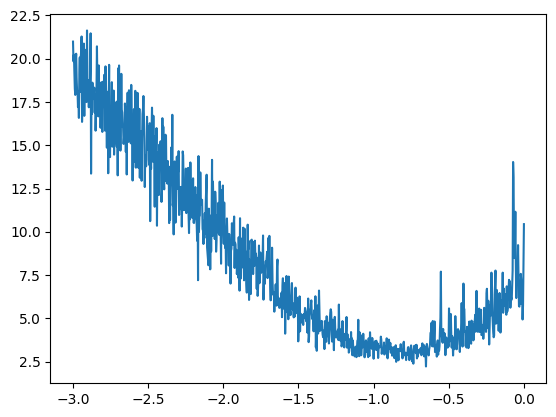

In [48]:
# examine the learning rates and loss
# plt.plot(lri, lossi)

# examine the exponents used to create the learning rates
plt.plot(lri, lossi)  # x-axis is the exponents of the learning rates 

In [49]:
# # evaluate the full dataset
# emb = C[X]
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# loss = F.cross_entropy(logits, Y)
# loss

In [50]:
# the graph of the exponents shows that the optimal learning rate exponent was around -1 --> learning rate 0.1

for i in range(10000):
    # forward pass
    
    # with mini-batch:
    ix = torch.randint(0, X.shape[0], (32,))  # sample size of 32
    
    emb = C[X[ix]] # (32, 3, 2) based on the sample size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
#    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
#    lr = 0.1
    lr = 0.01 # learning rate decay = smaller learning rate later in the training
    
    for p in parameters:
        p.data += - lr * p.grad  # gradient based on a smaller number of samples is less accurate
                                 # this is a trade-off for more/faster iterations of the process
    
# print(loss.item())

In [51]:
# evaluate the full dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5029, grad_fn=<NllLossBackward0>)

# Training, Validation and Test Data

In [52]:
# to prevent over training use splits; 80% training, 10% dev/validation, 10% test

In [53]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [54]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [55]:
# reset
# layers
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [56]:
for p in parameters:
    p.requires_grad = True

In [57]:
# with the training data

for i in range(30000):
    
    ix = torch.randint(0, Xtr.shape[0], (32,))  # sample size of 32
    
    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 2) based on the sample size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 
    
    for p in parameters:
        p.data += - lr * p.grad

In [58]:
print(loss.item())

2.239778995513916


In [59]:
# evaluate on the train dataset

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4027, grad_fn=<NllLossBackward0>)

In [60]:
# evaluate on the dev dataset

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3997, grad_fn=<NllLossBackward0>)

In [61]:
# this network is underfitting since the training loss and the dev loss are so close --> increase the number
# of parameters for the network

In [62]:
# increase the number of inputs to 300

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [63]:
sum(p.nelement() for p in parameters) # 10k instead of 3k

10281

In [64]:
for p in parameters:
    p.requires_grad = True

In [65]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    # forward pass
    
    # with mini-batch:
    ix = torch.randint(0, Xtr.shape[0], (32,))  # sample size of 32
    
    emb = C[Xtr[ix]] # (32, 3, 2) based on the sample size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    
    for p in parameters:
        p.data += - lr * p.grad  # gradient based on a smaller number of samples is less accurate
                                 # this is a trade-off for more/faster iterations of the process
     
    # tracking
    stepi.append(i)
    lossi.append(loss.item())
    
# print(loss.item())

24.1176700592041
24.828163146972656
29.081451416015625
26.469318389892578
29.511947631835938
23.293752670288086
23.416210174560547
17.819772720336914
30.24260139465332
24.550222396850586
20.51177978515625
21.119783401489258
17.886577606201172
26.631942749023438
23.87270736694336
24.943321228027344
23.676441192626953
25.02203369140625
21.175582885742188
18.025653839111328
21.817087173461914
24.724559783935547
24.604211807250977
17.074289321899414
19.17427635192871
18.03790855407715
21.760814666748047
16.812427520751953
24.479907989501953
22.28166961669922
22.1618595123291
19.305675506591797
17.21697425842285
18.377656936645508
19.258060455322266
18.73875617980957
19.560016632080078
14.072627067565918
19.917800903320312
20.730268478393555
20.697696685791016
19.206897735595703
16.394062042236328
19.85898208618164
22.050373077392578
19.514015197753906
21.895172119140625
16.311216354370117
16.57002830505371
17.505006790161133
15.847922325134277
19.145687103271484
22.677034378051758
17.79964

6.050536632537842
5.935965538024902
5.52682638168335
4.014791965484619
3.906367778778076
4.043915748596191
5.1098222732543945
6.096567153930664
4.080753326416016
4.521298408508301
4.028982639312744
6.218368053436279
5.056832790374756
7.1876349449157715
6.355352401733398
4.919997692108154
5.120889186859131
5.27913236618042
5.072732448577881
5.8506364822387695
5.100137710571289
5.114421367645264
4.680759906768799
5.602402687072754
4.560135841369629
3.8122098445892334
7.0847249031066895
3.753570318222046
4.303133010864258
3.1919920444488525
4.931415557861328
5.396888732910156
3.631309986114502
3.813875913619995
4.434659957885742
4.855737686157227
4.235023498535156
4.9343390464782715
4.276043891906738
6.382119178771973
5.852332592010498
5.093673229217529
5.549991130828857
3.5168442726135254
3.5205485820770264
3.779499053955078
5.016913890838623
4.176199436187744
6.4067487716674805
4.985176086425781
5.066859722137451
3.6292572021484375
5.50348424911499
5.944847583770752
5.054348468780518
5.

3.263298273086548
3.10601806640625
3.0202410221099854
3.6148507595062256
3.5913803577423096
3.6168065071105957
3.6127405166625977
3.702300786972046
3.212695598602295
3.775141954421997
3.1026241779327393
3.3822731971740723
4.223398685455322
2.9883837699890137
3.216696262359619
3.514200210571289
3.2069525718688965
2.8850438594818115
3.059526205062866
3.072431802749634
3.405906915664673
3.3174164295196533
3.3184309005737305
3.6028873920440674
3.6842262744903564
3.0806281566619873
2.6256356239318848
3.1396822929382324
3.483455181121826
3.297199249267578
3.1584253311157227
3.0350327491760254
2.901740312576294
3.108440637588501
2.7264530658721924
3.1454501152038574
2.8264577388763428
3.7648613452911377
2.755399227142334
3.885430335998535
2.9010047912597656
2.687673568725586
2.424119234085083
3.686000108718872
3.4080352783203125
3.840461015701294
3.482804775238037
2.4919445514678955
3.9940664768218994
3.0533604621887207
4.3398284912109375
3.4777779579162598
3.734287738800049
3.639750957489013

3.3647420406341553
2.7829229831695557
2.9817826747894287
2.662187337875366
3.204061985015869
2.9419264793395996
2.856606960296631
3.235431432723999
2.745716094970703
2.977020502090454
2.877032518386841
2.806525468826294
2.6293246746063232
3.9066803455352783
2.7569315433502197
2.994910478591919
2.8011245727539062
2.3177335262298584
3.136021852493286
2.3123409748077393
3.205901622772217
2.5966501235961914
2.9215216636657715
3.6945602893829346
2.674893856048584
2.9012393951416016
2.7337050437927246
2.8429293632507324
2.7757904529571533
2.497760772705078
2.612300395965576
3.5682106018066406
2.9675991535186768
2.826111316680908
2.8936405181884766
2.7834417819976807
2.45947265625
3.0768699645996094
2.920846939086914
2.7131052017211914
2.6462531089782715
3.1522955894470215
3.7307257652282715
2.8370842933654785
3.2018141746520996
3.3596420288085938
2.4500272274017334
2.3570713996887207
2.873857259750366
2.5028388500213623
2.788194417953491
3.572389841079712
2.8108127117156982
3.282565355300903

2.659990072250366
2.731466770172119
2.429485321044922
2.922558307647705
2.781233787536621
2.5996272563934326
3.791426181793213
2.5731515884399414
2.78912353515625
2.6215922832489014
3.0535953044891357
2.8062844276428223
3.0933876037597656
3.940901517868042
2.8184239864349365
2.3567068576812744
2.6922104358673096
2.556330442428589
2.8933534622192383
2.755749464035034
2.6712892055511475
2.829895257949829
2.9174814224243164
3.192568302154541
3.1889185905456543
3.038557529449463
3.1860527992248535
2.1982152462005615
2.7896056175231934
2.8347043991088867
2.870638370513916
2.5615856647491455
2.7912850379943848
2.813601016998291
2.7698612213134766
3.7948291301727295
2.689661979675293
3.4379632472991943
3.0621047019958496
3.252492904663086
3.6114535331726074
3.5662949085235596
3.1711106300354004
2.649564027786255
2.4565770626068115
2.8292393684387207
2.5084261894226074
2.4939558506011963
2.807295083999634
2.554509401321411
2.7919607162475586
2.25787091255188
2.6826303005218506
2.91488146781921

2.7803726196289062
2.646634578704834
3.443958282470703
2.447019100189209
2.471562623977661
3.25299072265625
2.7026119232177734
3.133333921432495
2.6356921195983887
2.9174931049346924
2.9032390117645264
2.8083815574645996
2.2863924503326416
2.7349400520324707
2.9549560546875
3.2635817527770996
2.4242494106292725
2.684213161468506
2.3994524478912354
2.8886172771453857
2.8619799613952637
2.410562038421631
2.662012815475464
2.427276611328125
2.8347718715667725
2.789153575897217
2.902255058288574
2.500880479812622
2.475731134414673
2.5490622520446777
2.274935483932495
2.6779487133026123
2.8735837936401367
2.3600666522979736
2.3886771202087402
3.0523340702056885
2.7966344356536865
2.693829298019409
2.7997405529022217
2.6359803676605225
2.7441234588623047
2.652977466583252
3.205521821975708
2.6065471172332764
2.5048744678497314
2.790560483932495
2.49943470954895
2.8982255458831787
2.8064465522766113
2.854274272918701
2.9123775959014893
2.4457473754882812
3.0893545150756836
3.0092251300811768


3.342766284942627
2.4557652473449707
2.3390350341796875
2.574998378753662
2.7781598567962646
2.461420774459839
2.167855739593506
2.2971818447113037
2.9290072917938232
3.112314462661743
2.908608913421631
2.7409064769744873
3.1399879455566406
2.9101223945617676
2.3460075855255127
3.2591195106506348
2.8909997940063477
2.521761417388916
2.350440502166748
2.6308014392852783
2.9252219200134277
2.947883367538452
2.404254674911499
2.819986343383789
2.8877644538879395
2.449796676635742
2.298497438430786
2.5724518299102783
2.758043050765991
2.7173211574554443
2.5546839237213135
2.6894161701202393
2.7388460636138916
2.5818991661071777
2.384265899658203
2.685407876968384
2.4630496501922607
2.423008680343628
2.529947280883789
3.2754909992218018
2.7555108070373535
2.1682934761047363
2.3532419204711914
2.712552070617676
2.7384018898010254
2.2796177864074707
2.5270862579345703
2.684765100479126
2.3593666553497314
2.2608020305633545
2.5581796169281006
2.399930238723755
2.9681336879730225
2.980888843536

2.386228322982788
2.359954833984375
2.7865633964538574
2.972820520401001
2.4340391159057617
2.6424198150634766
2.706336736679077
2.388939142227173
3.0271756649017334
2.5990822315216064
2.815229892730713
3.4329848289489746
2.5954811573028564
2.683610439300537
2.7999415397644043
2.4780309200286865
2.868032693862915
2.6991660594940186
2.6559712886810303
2.3487462997436523
2.2612669467926025
2.271517038345337
2.424268960952759
2.8415544033050537
2.5725035667419434
3.0937299728393555
2.853616714477539
2.968096971511841
2.55924129486084
2.6641576290130615
2.4984328746795654
2.4126336574554443
2.261615753173828
2.431286334991455
2.6410470008850098
2.440497398376465
2.7511420249938965
2.5284249782562256
2.6742537021636963
2.4227075576782227
2.361557722091675
2.8359291553497314
3.264404058456421
2.681697130203247
3.009835958480835
2.635732889175415
2.873753309249878
2.3659703731536865
2.934119701385498
2.993034601211548
2.5501763820648193
2.518404245376587
2.613438844680786
2.5302906036376953
2

2.385549783706665
2.9650776386260986
2.465529441833496
2.5447981357574463
2.4452340602874756
2.5391838550567627
2.3042821884155273
2.46193790435791
2.530747890472412
2.635478973388672
2.512688636779785
2.8540420532226562
2.482644557952881
2.593226432800293
3.6725356578826904
2.7038307189941406
3.296928882598877
3.1287803649902344
2.8110196590423584
2.5873279571533203
2.768491268157959
2.876751661300659
2.3791184425354004
2.7081077098846436
2.395864248275757
2.6459877490997314
2.277301073074341
2.4690539836883545
2.6007916927337646
2.2942557334899902
2.6158101558685303
2.9225597381591797
2.526942014694214
2.721752405166626
2.999126672744751
2.5420122146606445
2.5031261444091797
2.6325528621673584
2.3905248641967773
2.4421114921569824
2.4268429279327393
2.4701972007751465
2.6984663009643555
2.703799247741699
2.589632749557495
2.538529396057129
3.0933101177215576
2.342040538787842
2.6359035968780518
3.1135239601135254
2.5191407203674316
2.5465800762176514
2.625948905944824
2.6678607463836

2.4816856384277344
2.5090770721435547
2.5290932655334473
3.035994529724121
2.5039262771606445
2.258049964904785
2.689689874649048
2.529247999191284
2.4388344287872314
2.8245368003845215
2.623065948486328
2.36999773979187
2.9463562965393066
2.3562567234039307
2.608415126800537
2.1415975093841553
2.638563394546509
2.2281196117401123
2.1447415351867676
2.4653782844543457
2.3247289657592773
2.7995102405548096
2.63063383102417
2.4823338985443115
3.6129796504974365
2.7582807540893555
2.287702798843384
2.4936962127685547
2.4202330112457275
2.1988086700439453
2.215402126312256
2.7190539836883545
2.723024368286133
2.4709126949310303
2.75710129737854
2.495110273361206
2.64243745803833
2.312763214111328
2.8121235370635986
2.4493308067321777
2.2996299266815186
2.77726411819458
2.6443049907684326
2.5915534496307373
2.5448997020721436
2.641887903213501
2.62448787689209
2.709041118621826
2.658846378326416
2.427448272705078
3.0367796421051025
2.828490972518921
2.231369972229004
2.6427414417266846
2.54

2.5017194747924805
2.165465831756592
2.2902650833129883
2.6222596168518066
2.563791275024414
2.6198110580444336
2.618959903717041
2.4536237716674805
3.3789799213409424
2.7075612545013428
2.6356759071350098
2.4048361778259277
2.6610617637634277
2.5733985900878906
2.6483731269836426
2.5665230751037598
2.7660489082336426
2.7943408489227295
2.2239601612091064
2.5796985626220703
2.2565581798553467
2.526498794555664
2.4413070678710938
2.457721710205078
2.594637632369995
2.337184190750122
2.4385910034179688
2.3731961250305176
2.7215704917907715
2.800650119781494
2.546726703643799
2.811636447906494
2.572249174118042
2.4786343574523926
2.340794324874878
2.609701156616211
2.4411962032318115
2.5686984062194824
2.5097293853759766
2.771639108657837
2.6829311847686768
2.785569906234741
2.5336790084838867
2.2740392684936523
2.742103099822998
2.310826301574707
2.5599091053009033
2.8124661445617676
2.4361562728881836
2.7948267459869385
2.690300464630127
2.8967080116271973
2.686800003051758
2.9166502952

2.756575345993042
2.495770215988159
2.4413418769836426
3.1099305152893066
2.7543911933898926
2.3087515830993652
2.4404799938201904
2.4111557006835938
2.3901119232177734
2.673898935317993
2.4660215377807617
2.679131507873535
2.6552963256835938
2.3767294883728027
2.615260601043701
2.4054012298583984
2.524012804031372
2.636228084564209
2.72137188911438
2.6889560222625732
2.3650436401367188
2.7052056789398193
2.393981695175171
2.5660550594329834
2.6486830711364746
2.470259189605713
2.532074213027954
2.426596164703369
2.2773642539978027
2.625784397125244
2.98858642578125
3.0050418376922607
2.741259813308716
2.5251317024230957
2.7809300422668457
2.798037052154541
2.3253448009490967
2.2053849697113037
2.3644015789031982
2.6245789527893066
2.279660940170288
2.8307268619537354
2.4625327587127686
2.762768030166626
2.525444746017456
2.8958992958068848
2.0599124431610107
2.9561755657196045
2.677152633666992
2.729218006134033
2.537665605545044
2.385512351989746
2.414064645767212
3.0192105770111084


2.59011173248291
2.2000889778137207
2.416342258453369
2.366924524307251
2.6836042404174805
2.9614360332489014
2.4890244007110596
2.7116055488586426
2.716529607772827
2.6863455772399902
2.301401376724243
2.8110873699188232
2.510967254638672
2.739403247833252
2.4120960235595703
2.8777706623077393
2.9771814346313477
2.6850430965423584
2.5649900436401367
2.437410593032837
2.565138816833496
2.8455421924591064
2.3457188606262207
2.721231698989868
2.5511114597320557
2.565262794494629
2.969633102416992
2.06972336769104
2.6339364051818848
2.7596263885498047
2.4738547801971436
2.2218470573425293
2.468386173248291
2.458946943283081
2.626030921936035
2.2611160278320312
2.3179409503936768
2.224433183670044
2.879528522491455
2.8644142150878906
2.893540382385254
2.564922571182251
2.6895182132720947
2.857468843460083
2.720531463623047
2.6388022899627686
2.6169536113739014
2.7530789375305176
2.415041446685791
2.5358409881591797
2.1017491817474365
2.623244524002075
2.4263856410980225
2.767038106918335
2

2.899439811706543
3.1416752338409424
2.6439366340637207
2.4995226860046387
2.9373536109924316
2.5542447566986084
2.4959278106689453
2.295212507247925
2.247457265853882
2.5855863094329834
2.7705674171447754
2.6590795516967773
2.2978975772857666
2.6384620666503906
2.4865927696228027
2.3261091709136963
2.397002935409546
2.7024853229522705
2.278400182723999
2.472102403640747
2.1760780811309814
2.3093221187591553
2.3030242919921875
2.343874931335449
2.348662853240967
2.185136079788208
2.31727933883667
2.6546096801757812
2.1655521392822266
2.844895601272583
2.5390682220458984
3.1637368202209473
2.4285807609558105
2.4571993350982666
2.431676149368286
2.461193561553955
2.83606219291687
2.624181032180786
2.5605838298797607
2.389195442199707
2.7196450233459473
2.6580605506896973
2.404442071914673
2.287177085876465
2.7210354804992676
2.613894462585449
2.6697232723236084
2.711625576019287
2.4288904666900635
2.529116630554199
2.710284948348999
2.7600619792938232
2.866360902786255
2.2122483253479004

2.744201183319092
2.5008296966552734
2.504317045211792
2.667715311050415
2.42954421043396
2.434307336807251
2.6933999061584473
2.459402561187744
2.7926342487335205
2.5739762783050537
2.235844373703003
2.594571828842163
3.0969839096069336
2.939056634902954
2.5311763286590576
2.4073221683502197
3.2206101417541504
2.596351385116577
2.708568811416626
2.7698168754577637
2.353095531463623
2.573333978652954
2.7026572227478027
2.5068821907043457
2.2207844257354736
2.1568777561187744
2.261070966720581
2.4426326751708984
2.902747631072998
2.6549201011657715
2.1445419788360596
2.677798271179199
2.371015787124634
2.433199167251587
3.0664708614349365
2.3042593002319336
2.5611672401428223
2.5366296768188477
2.5149354934692383
2.985354423522949
3.2239608764648438
2.525965452194214
2.540703535079956
2.6791272163391113
2.528409719467163
2.566248655319214
2.440364122390747
2.543543815612793
2.455167293548584
2.4456939697265625
2.4751787185668945
2.8767759799957275
2.597825288772583
2.5759384632110596
2.

2.4645020961761475
2.4259884357452393
2.504478693008423
2.6154801845550537
2.538635730743408
2.731915235519409
2.335050106048584
2.6668617725372314
2.6063969135284424
2.60073184967041
2.530034065246582
2.651165723800659
2.4533400535583496
2.8641488552093506
2.8316609859466553
2.6705987453460693
2.441991090774536
1.9682170152664185
2.799147129058838
2.8061118125915527
2.600271224975586
2.2573368549346924
2.9689133167266846
2.992316961288452
2.4979639053344727
2.389251232147217
2.8494441509246826
2.453007698059082
2.4937219619750977
2.7445569038391113
2.4583117961883545
2.9947803020477295
2.194643974304199
2.8111164569854736
2.5075464248657227
2.6091830730438232
2.886697292327881
2.555111885070801
2.391740322113037
2.1709163188934326
2.4943647384643555
2.6621828079223633
2.3035058975219727
1.9534229040145874
2.2291488647460938
2.392925977706909
2.61273455619812
2.9534826278686523
2.357043981552124
2.8158557415008545
2.5590083599090576
2.608588218688965
2.553471803665161
2.674016952514648

2.4569926261901855
2.6969544887542725
2.4231185913085938
2.598384141921997
2.104691743850708
2.43404221534729
2.686504364013672
2.5320212841033936
2.430129051208496
2.96990966796875
2.3268041610717773
2.6881208419799805
2.646611452102661
2.396876811981201
2.7598769664764404
2.5674562454223633
2.3395867347717285
2.608532667160034
2.453082323074341
2.4654557704925537
2.4184834957122803
2.717586040496826
2.616771936416626
2.6549720764160156
2.310319423675537
2.33504056930542
2.897887945175171
2.3543546199798584
2.5564444065093994
2.353900909423828
2.4230966567993164
2.4879631996154785
2.442201614379883
2.506519079208374
2.6846516132354736
2.4749505519866943
3.136221170425415
2.3374760150909424
2.7281930446624756
2.8198680877685547
2.325333833694458
2.9605257511138916
2.9623310565948486
2.8487656116485596
2.9450788497924805
2.7726361751556396
2.6667873859405518
2.334503173828125
2.3405637741088867
2.424142837524414
2.83469557762146
2.574274778366089
2.3406341075897217
2.473944902420044
2.3

2.456942319869995
2.479959011077881
2.8078999519348145
2.5854976177215576
2.8264262676239014
2.527837038040161
2.8901326656341553
2.7837209701538086
2.6481661796569824
2.470918655395508
2.776923418045044
2.1935343742370605
2.398952007293701
2.2451937198638916
2.580519676208496
2.5892717838287354
2.500027656555176
2.544558525085449
2.444000244140625
2.4472768306732178
2.781587600708008
2.387059211730957
2.984884023666382
2.1575732231140137
2.8482160568237305
2.273190498352051
2.814305305480957
2.520660638809204
2.667353391647339
2.3409695625305176
2.3561348915100098
2.5480546951293945
2.5610952377319336
2.545518398284912
2.5303192138671875
2.6683108806610107
2.2908506393432617
2.397986650466919
2.4652838706970215
2.390190839767456
2.671555519104004
2.4301936626434326
2.6917779445648193
2.4683151245117188
2.6503565311431885
2.6016035079956055
2.42515230178833
2.352173089981079
2.219329357147217
2.2806711196899414
2.4604172706604004
2.702315092086792
2.301269769668579
2.5852298736572266
2

2.306649923324585
2.7184946537017822
2.8622052669525146
2.613077163696289
2.753784418106079
2.1794140338897705
2.400381088256836
2.9934709072113037
2.165120840072632
2.252532720565796
2.463221311569214
2.536489725112915
2.62591814994812
2.7817578315734863
2.7353291511535645
2.704517364501953
2.9780972003936768
2.5152556896209717
2.879115104675293
2.489684820175171
2.301253318786621
2.581449031829834
2.4323012828826904
2.3104982376098633
2.226954221725464
2.3044886589050293
2.3264782428741455
2.744231700897217
2.341777801513672
2.4769446849823
2.3751614093780518
2.9213078022003174
2.373239040374756
2.31976318359375
2.22683048248291
2.440302848815918
2.9571666717529297
2.279356002807617
2.509376287460327
2.694457769393921
2.535172700881958
2.446634531021118
2.531334161758423
2.0462758541107178
2.3988819122314453
2.5902528762817383
2.4550015926361084
2.6706771850585938
2.570180654525757
2.169811725616455
2.6698765754699707
2.1758577823638916
2.996636390686035
2.6716225147247314
2.51854062

2.57075572013855
2.53029465675354
2.3560848236083984
2.279492139816284
2.271556854248047
2.719789981842041
2.6735033988952637
3.0375711917877197
2.575230360031128
2.85666823387146
2.5483217239379883
2.4180970191955566
2.9344418048858643
2.810447931289673
2.6879899501800537
2.7410597801208496
2.7227237224578857
2.56954026222229
2.718996286392212
2.4961187839508057
2.658748149871826
2.6444284915924072
2.3141067028045654
2.553478717803955
2.6037185192108154
2.4772751331329346
2.483112096786499
2.0443978309631348
2.0922892093658447
2.375227212905884
2.5942115783691406
2.5125601291656494
2.466825008392334
2.7526192665100098
2.3765511512756348
2.5308752059936523
2.540668487548828
2.371044158935547
2.422006845474243
2.5943410396575928
2.921328067779541
2.443993091583252
2.184159278869629
2.7353906631469727
2.129547119140625
2.403021812438965
2.1962480545043945
2.4513981342315674
2.2272822856903076
2.243490219116211
2.614419460296631
2.470571517944336
1.8240299224853516
2.746988534927368
2.443

2.4206290245056152
2.637502431869507
2.290408134460449
2.646996021270752
2.5722522735595703
2.609494686126709
2.49596905708313
2.5116806030273438
2.478823184967041
2.4937641620635986
2.827099561691284
2.3040249347686768
2.6775360107421875
2.6982688903808594
2.5956685543060303
2.429140567779541
2.303947925567627
2.9153692722320557
2.7110283374786377
2.001439094543457
2.179422378540039
2.816087245941162
2.503857374191284
2.2427523136138916
2.591902494430542
2.511915445327759
2.3962671756744385
2.6571130752563477
2.267160177230835
2.613067150115967
2.2894484996795654
2.333974599838257
2.861997604370117
2.2853424549102783
2.497879981994629
2.492644786834717
2.2108795642852783
2.4151487350463867
2.461380958557129
2.4234673976898193
2.5512771606445312
2.1767497062683105
2.5968127250671387
2.8521664142608643
2.1796987056732178
2.930406093597412
2.092989444732666
2.3356401920318604
2.4202373027801514
2.4065792560577393
2.8429224491119385
2.4838991165161133
2.7660224437713623
2.0378758907318115

2.309133768081665
3.1726200580596924
2.4336116313934326
2.666121006011963
2.4729256629943848
2.1224896907806396
2.411463499069214
2.576990842819214
2.4146058559417725
2.778132200241089
2.4551546573638916
2.4097392559051514
2.622528553009033
2.1540801525115967
2.52195405960083
2.470660924911499
2.302186965942383
2.526041269302368
2.6290252208709717
2.845090627670288
2.3861467838287354
2.398822546005249
2.2475242614746094
2.6482200622558594
2.390486478805542
2.4923622608184814
2.7624499797821045
2.611906051635742
2.304626226425171
2.56063175201416
2.3805582523345947
2.806716203689575
2.679246187210083
2.4180848598480225
2.4626142978668213
2.370210886001587
2.186518669128418
2.899566888809204
2.9787890911102295
2.788331985473633
2.2746150493621826
2.235994577407837
2.3320415019989014
2.2465035915374756
2.4129834175109863
2.5992751121520996
2.3693625926971436
2.542818546295166
2.638828754425049
2.3663110733032227
2.907094717025757
2.69374680519104
2.242400646209717
2.3607444763183594
2.624

2.5363526344299316
2.345113754272461
2.435965061187744
2.4546236991882324
2.4437625408172607
2.373096227645874
2.4021008014678955
2.6729907989501953
2.709394931793213
2.2272751331329346
2.5383946895599365
2.80519700050354
2.3725626468658447
2.2102060317993164
2.5368738174438477
2.772329807281494
2.14949631690979
2.6679210662841797
2.1674067974090576
2.2375524044036865
2.428820848464966
2.4106030464172363
2.414027690887451
2.615490674972534
2.42179536819458
2.6958608627319336
2.900529623031616
2.365044355392456
2.468217134475708
2.79313063621521
2.9481072425842285
2.817599296569824
2.6145005226135254
2.5938801765441895
2.449486494064331
2.6053965091705322
2.53893780708313
2.3893511295318604
2.8089401721954346
2.5790607929229736
2.5460190773010254
2.443239450454712
2.683067798614502
2.408968448638916
2.604358673095703
2.452364683151245
2.4723849296569824
2.6651198863983154
2.4053165912628174
2.8888285160064697
2.4611704349517822
2.7321150302886963
2.18719482421875
2.3708624839782715
2.66

2.3795814514160156
2.6291372776031494
2.46718430519104
2.8216731548309326
2.6715049743652344
2.377690315246582
2.865849733352661
2.3937466144561768
2.490180253982544
2.4899590015411377
2.5013067722320557
2.6446900367736816
2.3441872596740723
2.475813150405884
3.1733381748199463
2.6718454360961914
2.7484521865844727
2.6650919914245605
2.221531391143799
3.287508010864258
2.7232754230499268
2.4926929473876953
2.36914324760437
2.5135834217071533
2.4511301517486572
2.5954477787017822
2.550290107727051
2.645509719848633
2.5316531658172607
2.6621508598327637
2.3507332801818848
3.021376609802246
2.3511674404144287
2.5231261253356934
2.5056943893432617
2.415717601776123
2.2302284240722656
2.500002145767212
2.431410312652588
2.4744796752929688
2.5039126873016357
2.687147378921509
2.2563936710357666
2.4981980323791504
2.1720235347747803
2.1656494140625
2.8452539443969727
2.5152926445007324
2.245699644088745
2.1449766159057617
2.6328184604644775
2.238236427307129
2.4076547622680664
2.4470088481903

2.4167611598968506
2.564234495162964
2.1328086853027344
2.6574389934539795
2.905928134918213
2.4331858158111572
2.423081874847412
2.372910976409912
2.8286001682281494
2.563458204269409
2.5468990802764893
2.423518657684326
2.510481357574463
2.7226662635803223
2.2134833335876465
2.841883659362793
3.02400541305542
2.4262101650238037
2.309912919998169
2.26147198677063
2.1518852710723877
2.5102779865264893
2.4312498569488525
2.537135601043701
2.5214600563049316
2.203002452850342
2.8415653705596924
3.138084650039673
2.5470728874206543
2.5205767154693604
2.4453811645507812
2.456432342529297
2.759479522705078
2.5050101280212402
2.347929000854492
2.529844284057617
2.764702081680298
2.514817714691162
2.6938908100128174
2.46677303314209
2.754686117172241
2.5147557258605957
2.5271053314208984
2.4957172870635986
2.2282345294952393
2.6972782611846924
2.6949753761291504
2.5092835426330566
2.5606441497802734
2.67128586769104
2.826366424560547
2.6058175563812256
2.5142412185668945
2.3335440158843994
2.

2.5442848205566406
2.368185043334961
2.53859806060791
2.4844512939453125
2.5976972579956055
2.753871440887451
2.426414966583252
2.785902976989746
2.606687307357788
2.4528350830078125
2.7383029460906982
2.602407217025757
2.6464457511901855
2.3405094146728516
2.5192246437072754
2.4757351875305176
2.6629891395568848
2.3589842319488525
2.7808072566986084
2.4016268253326416
2.80466890335083
2.461534023284912
2.695892810821533
2.42443585395813
2.5798614025115967
2.886502981185913
2.3442797660827637
2.647688388824463
2.7790489196777344
2.695340394973755
2.3529539108276367
2.209303379058838
2.243032217025757
2.4010303020477295
2.3885035514831543
2.514864206314087
2.5320074558258057
2.432645797729492
2.817312002182007
3.0294926166534424
2.868117332458496
2.500516176223755
2.5231614112854004
2.6164822578430176
2.471416473388672
2.488081216812134
2.853938102722168
3.1465694904327393
2.346672534942627
2.8756818771362305
2.364251136779785
2.4059267044067383
2.2046544551849365
2.5722217559814453
2.5

2.331247568130493
2.399362802505493
2.3353962898254395
2.49052357673645
2.236862897872925
2.274601936340332
2.811530351638794
2.397796869277954
2.535022497177124
2.3712477684020996
2.525662422180176
2.72182035446167
2.480616569519043
2.316906690597534
2.3541102409362793
2.42170786857605
2.758944034576416
2.605212688446045
2.610311269760132
2.8926897048950195
2.792304754257202
2.155817747116089
2.511974573135376
2.2997498512268066
2.5022847652435303
2.535227060317993
2.453449010848999
2.2201929092407227
2.74112868309021
2.7072041034698486
2.4189863204956055
2.268613576889038
2.5522079467773438
2.316305637359619
2.654144287109375
2.1579480171203613
3.1704018115997314
2.172985553741455
2.7060582637786865
2.6172592639923096
2.7671990394592285
2.3984785079956055
2.303530216217041
2.765218496322632
2.4483141899108887
2.201404333114624
2.7355973720550537
2.1867668628692627
2.3194541931152344
2.7028307914733887
2.1655943393707275
2.496828317642212
2.757322311401367
2.5709078311920166
2.7789175

2.4386630058288574
2.519423246383667
2.6981470584869385
2.813793420791626
2.405726909637451
2.373692512512207
2.4319331645965576
2.4763617515563965
2.39046049118042
2.4800562858581543
2.5649290084838867
2.4614620208740234
2.59358286857605
3.0188753604888916
2.6195106506347656
2.0099306106567383
2.8976690769195557
2.534198760986328
2.753448009490967
2.338024377822876
2.8451902866363525
2.464466094970703
2.282210111618042
2.813375473022461
2.5861780643463135
2.2596964836120605
2.453949451446533
2.7086679935455322
2.7076313495635986
2.6877245903015137
2.418056011199951
2.3807549476623535
2.7338173389434814
2.215329647064209
2.6130199432373047
2.4284286499023438
2.724891424179077
2.2671289443969727
2.338536500930786
2.4378716945648193
2.4934942722320557
2.714996576309204
2.596424102783203
2.6734774112701416
2.7029993534088135
2.718482494354248
2.7081992626190186
2.1418097019195557
2.2642364501953125
2.5535004138946533
2.4395558834075928
2.518497943878174
2.8029558658599854
2.14154672622680

2.5050973892211914
2.6965646743774414
2.400014638900757
2.2699055671691895
2.3580398559570312
2.2808048725128174
2.760263442993164
2.1383347511291504
2.7956395149230957
2.3083512783050537
2.624413013458252
2.8892581462860107
2.6477534770965576
2.575733184814453
2.5612382888793945
2.4451606273651123
2.846626043319702
2.1025807857513428
2.505967855453491
2.3201498985290527
2.2244389057159424
2.238095760345459
2.3960494995117188
2.44643235206604
2.5291295051574707
2.51958966255188
2.1798934936523438
2.5940945148468018
2.27189040184021
2.772876739501953
2.600844621658325
2.4073164463043213
2.5199437141418457
2.523146390914917
2.32242751121521
2.3008341789245605
2.7131733894348145
2.4905030727386475
2.2519569396972656
2.4325287342071533
2.255453586578369
2.45597505569458
2.1475183963775635
2.869795083999634
2.1984829902648926
2.454404592514038
2.4111111164093018
2.28934383392334
2.625919818878174
2.465928316116333
2.639486789703369
1.9584990739822388
2.211517095565796
2.599025249481201
2.54

2.649259567260742
2.548370122909546
2.7978200912475586
2.4997828006744385
2.37420392036438
2.6517393589019775
2.744232654571533
2.2891573905944824
2.0319554805755615
2.3793764114379883
2.386167526245117
2.2737252712249756
2.3576767444610596
3.1786882877349854
2.257478713989258
2.402221202850342
2.326855421066284
2.6407535076141357
2.4282562732696533
2.3399314880371094
2.5381274223327637
2.543779134750366
2.5347464084625244
2.5103979110717773
2.3721487522125244
2.4114596843719482
2.8557941913604736
2.6931142807006836
2.468628168106079
2.516230583190918
3.0227816104888916
2.1688506603240967
2.567202568054199
2.446340560913086
2.5388965606689453
3.017421007156372
2.915544271469116
2.6316444873809814
2.29439377784729
2.3789432048797607
2.2943007946014404
2.852351427078247
2.6637942790985107
2.1948747634887695
2.479529857635498
2.3058435916900635
2.345057249069214
2.59639835357666
2.456035614013672
2.730508327484131
2.514097213745117
3.060086488723755
2.368149757385254
2.8101651668548584
2.

2.6692914962768555
2.47860050201416
2.5049831867218018
2.6902801990509033
2.590036630630493
2.1377875804901123
2.3296892642974854
2.4598770141601562
2.426741600036621
2.6665892601013184
2.5041937828063965
2.4244930744171143
2.4600648880004883
2.0005030632019043
2.552154302597046
2.156249761581421
2.636941432952881
2.758742094039917
2.743171215057373
2.474775791168213
2.377182960510254
2.555635452270508
2.6235897541046143
2.9700090885162354
2.6827054023742676
2.446532964706421
2.2210559844970703
2.6492228507995605
2.705315589904785
2.1963982582092285
2.4238743782043457
2.7162420749664307
2.3151133060455322
2.970336675643921
2.4943337440490723
2.6444272994995117
2.7814888954162598
2.58400297164917
2.572640895843506
2.304290294647217
2.620537757873535
2.8695456981658936
2.602109909057617
2.5155115127563477
2.15501070022583
2.816303253173828
2.625459909439087
2.5018012523651123
2.4684715270996094
2.5734190940856934
2.186265230178833
2.6580517292022705
2.822746992111206
2.3295183181762695
2

2.429896116256714
2.247565269470215
2.6069650650024414
2.131834030151367
2.1278672218322754
2.3567049503326416
2.505674123764038
2.6045901775360107
2.644618272781372
2.299039363861084
2.2891173362731934
2.4167025089263916
2.6447525024414062
2.248922348022461
2.7123260498046875
2.363893508911133
2.4151554107666016
2.276163101196289
2.657231569290161
2.584988594055176
2.316744327545166
2.510230779647827
2.3739516735076904
2.369248867034912
2.664071798324585
2.3604001998901367
2.590686321258545
2.5530290603637695
2.479822874069214
2.398439407348633
2.5217833518981934
2.20527720451355
2.395714044570923
2.3636703491210938
2.611013650894165
2.3092446327209473
2.302539110183716
2.737884521484375
2.281705379486084
2.546574592590332
2.435490608215332
2.619074821472168
2.2663028240203857
2.2362217903137207
2.4614357948303223
2.3544466495513916
2.5945847034454346
2.1825404167175293
2.5925567150115967
2.4046778678894043
2.5204250812530518
2.888463258743286
2.370187759399414
2.409666061401367
2.882

2.6447668075561523
2.6166932582855225
2.4337520599365234
2.4827277660369873
2.371324300765991
2.3633084297180176
2.92314076423645
2.338850498199463
2.125382423400879
2.5959577560424805
2.4876656532287598
2.2837443351745605
2.4353668689727783
2.4208648204803467
2.4220101833343506
2.722480058670044
2.1590919494628906
2.7605350017547607
2.5824167728424072
2.787855863571167
2.6271586418151855
2.483693838119507
2.2644824981689453
2.4329893589019775
2.5995216369628906
2.505584955215454
2.5418107509613037
2.2677998542785645
2.6606369018554688
2.3149728775024414
2.5880484580993652
2.096268653869629
2.62692928314209
2.4535105228424072
2.7217249870300293
2.2432332038879395
2.2476179599761963
2.261430263519287
2.89335560798645
2.0974514484405518
2.5335757732391357
2.3600969314575195
2.031151294708252
2.7131760120391846
2.42189359664917
2.1503822803497314
2.500566244125366
2.370969533920288
2.4926772117614746
2.478708505630493
2.3895456790924072
2.3901028633117676
2.3600335121154785
2.377132892608

2.5412659645080566
2.6706595420837402
2.8074820041656494
2.329848289489746
2.244044065475464
2.5581395626068115
2.3324508666992188
2.6955180168151855
2.877840518951416
2.6712207794189453
2.520235061645508
2.509287118911743
2.6649086475372314
2.571744680404663
2.3879776000976562
2.85302734375
2.5415079593658447
2.644833564758301
2.411756753921509
2.6928915977478027
2.2723076343536377
2.4660677909851074
2.2983429431915283
2.3581221103668213
2.3790206909179688
2.4993159770965576
2.2877655029296875
2.4305145740509033
2.1357619762420654
2.5574986934661865
2.2355477809906006
2.379951238632202
2.7121331691741943
2.3250186443328857
2.633256435394287
2.7714405059814453
2.530977249145508
2.7513701915740967
2.466299533843994
2.469236135482788
2.303675651550293
2.37896728515625
2.2545058727264404
2.6697065830230713
2.63736891746521
2.158806324005127
2.5324995517730713
2.275331974029541
2.389270782470703
2.511800527572632
2.512472152709961
2.6605842113494873
2.370661497116089
3.1309163570404053
2.2

2.2789249420166016
2.438717842102051
2.5327394008636475
2.455181837081909
2.475825548171997
2.3914108276367188
2.451669692993164
2.532095193862915
2.231781005859375
2.589407444000244
2.3796584606170654
2.4662575721740723
2.7179415225982666
2.463265895843506
2.5926473140716553
2.350748300552368
2.401235342025757
2.369335412979126
2.590158462524414
2.4724926948547363
2.3363094329833984
2.268866539001465
2.3945343494415283
2.2241621017456055
2.436258554458618
2.586118459701538
2.3917605876922607
2.1033742427825928
2.5525617599487305
2.3423047065734863
2.4581918716430664
2.217989921569824
2.7484049797058105
2.360872268676758
2.3756561279296875
2.4012999534606934
2.605663537979126
2.184588670730591
2.8203344345092773
2.2604777812957764
2.179227113723755
2.160055160522461
2.6522843837738037
2.4419281482696533
2.164199113845825
2.3682126998901367
2.1236555576324463
2.5760860443115234
2.540222644805908
2.5896294116973877
2.489267110824585
2.390166997909546
2.512913227081299
2.6931982040405273


2.2210779190063477
2.8683011531829834
2.60782527923584
2.3112637996673584
2.6631369590759277
2.7153642177581787
2.228121280670166
2.373671293258667
2.533601999282837
2.385072708129883
2.452814817428589
2.3992092609405518
2.5431926250457764
2.5200047492980957
2.3359789848327637
3.0696582794189453
2.3779895305633545
2.937124252319336
2.14961314201355
2.5711636543273926
2.6834394931793213
2.790600538253784
2.5168871879577637
2.183791399002075
2.1434202194213867
2.072838544845581
2.621602773666382
2.6350936889648438
2.3411190509796143
2.6240224838256836
2.499187707901001
2.290381669998169
2.4116697311401367
2.4312427043914795
2.9732420444488525
2.449211835861206
2.339231252670288
2.623830556869507
2.729793071746826
2.3852524757385254
2.566061496734619
2.2683162689208984
2.816373348236084
2.490797519683838
2.6912286281585693
2.465785503387451
2.227351188659668
2.4048690795898438
2.7098658084869385
2.109185218811035
2.388112783432007
2.566096782684326
2.354456663131714
2.4029128551483154
2.3

2.494785785675049
2.7379353046417236
2.302502155303955
2.747730016708374
2.4846060276031494
2.1817030906677246
2.861670970916748
2.597752809524536
2.6392722129821777
2.7516250610351562
2.1927003860473633
2.0643582344055176
2.8116674423217773
2.3769421577453613
2.7105712890625
2.4152004718780518
2.5636446475982666
2.3551459312438965
2.837850570678711
2.6149516105651855
2.252547025680542
2.2361085414886475
2.658703327178955
2.8555984497070312
2.517357110977173
2.3747360706329346
2.4101316928863525
2.8774466514587402
2.5685110092163086
2.1161932945251465
2.589757204055786
2.4199676513671875
2.4305920600891113
2.5626304149627686
2.5038979053497314
2.2986483573913574
2.4177024364471436
2.3076815605163574
2.5111615657806396
2.1734495162963867
2.587742328643799
2.4454236030578613
2.32041597366333
2.5222654342651367
2.7550759315490723
2.7777321338653564
2.639232873916626
2.527898073196411
2.480018138885498
2.2983129024505615
2.6960268020629883
2.4385218620300293
2.6366569995880127
2.4913055896

2.3497488498687744
2.466536521911621
2.615919589996338
2.590758800506592
2.071805000305176
2.5128250122070312
2.029421329498291
2.45857572555542
2.6781954765319824
2.888641834259033
2.3023953437805176
2.0425117015838623
2.1801528930664062
2.2453017234802246
2.3226118087768555
2.570275068283081
2.1666436195373535
2.6952168941497803
2.578472852706909
2.5981225967407227
2.3805959224700928
2.507610321044922
2.186217784881592
2.6071090698242188
2.502549171447754
2.7527830600738525
2.3519911766052246
2.563974380493164
2.3596384525299072
2.3622658252716064
2.665956497192383
2.9848358631134033
2.5467944145202637
2.4669721126556396
2.7674403190612793
2.3021998405456543
2.222862958908081
2.3428244590759277
2.629899501800537
2.4435935020446777
2.783693552017212
2.247236728668213
2.7808191776275635
2.7223575115203857
2.4233791828155518
2.377912998199463
2.7818057537078857
3.0773561000823975
2.3653478622436523
2.0015370845794678
2.6822633743286133
2.6270413398742676
2.30669903755188
2.5754764080047

2.44413423538208
2.766167163848877
2.4544620513916016
2.506469488143921
2.649423837661743
2.240191698074341
2.606180191040039
2.44289493560791
2.4018285274505615
2.4588398933410645
2.765371322631836
2.4689955711364746
2.5396981239318848
2.48172926902771
2.6054484844207764
2.704145908355713
2.242213487625122
2.4400367736816406
2.6943001747131348
2.184307336807251
2.1516804695129395
2.279052734375
2.214747905731201
2.5032224655151367
2.3371002674102783
2.7862493991851807
2.4095234870910645
2.4000043869018555
2.6354384422302246
2.4906561374664307
2.2998034954071045
2.6413817405700684
2.653860330581665
2.2483105659484863
2.394355058670044
2.2829506397247314
2.5935258865356445
2.1620476245880127
2.5145769119262695
2.263622999191284
2.242638349533081
2.496866464614868
2.7142717838287354
2.294595718383789
2.6315646171569824
2.338609218597412
1.950957179069519
2.373677968978882
2.484703302383423
2.3416054248809814
2.3751468658447266
2.512904167175293
2.9715898036956787
2.262537956237793
2.4773

2.3482258319854736
2.629615306854248
2.2161128520965576
2.2221686840057373
2.4273664951324463
2.646815299987793
2.4005074501037598
2.3228232860565186
2.234711170196533
2.783499240875244
2.4907875061035156
2.3594167232513428
2.823535919189453
2.703500270843506
2.2968082427978516
2.336063861846924
2.382455587387085
2.3223607540130615
2.43656063079834
2.5386223793029785
2.5737173557281494
2.5467491149902344
2.1726114749908447
2.4837539196014404
2.586566209793091
2.180224895477295
2.5199174880981445
2.8743951320648193
2.5352587699890137
2.2385895252227783
2.262192726135254
2.4886972904205322
2.1890146732330322
2.490950107574463
2.5366933345794678
2.619580030441284
2.228788375854492
2.372512102127075
2.604294538497925
2.279191017150879
2.7783682346343994
2.5777251720428467
2.5721468925476074
2.6036829948425293
2.2741527557373047
2.408341646194458
2.6980140209198
2.3183958530426025
2.6251721382141113
2.411712646484375
2.275200366973877
2.757044792175293
2.4779772758483887
2.324504852294922
2

2.3717257976531982
2.7741801738739014
2.8362679481506348
2.4950406551361084
2.183047294616699
2.36319637298584
2.4466464519500732
2.303053855895996
2.2803943157196045
2.7412290573120117
2.072481870651245
2.8233656883239746
2.4726476669311523
2.229102373123169
2.612577199935913
2.519282817840576
2.555462598800659
2.551175832748413
2.530749797821045
2.6729774475097656
2.3163199424743652
2.334407091140747
2.325363874435425
2.6937308311462402
2.6082875728607178
2.4153192043304443
2.2157485485076904
2.4718711376190186
2.56321120262146
2.590640068054199
2.3695995807647705
2.4384918212890625
2.1506383419036865
2.1507787704467773
2.408902883529663
2.6591074466705322
2.3246607780456543
2.266251802444458
2.483567953109741
2.2362663745880127
2.416710615158081
2.5201938152313232
2.3813490867614746
2.5510735511779785
2.3552067279815674
2.761556386947632
2.8297524452209473
2.481830596923828
2.650006055831909
2.540543794631958
2.269357919692993
2.1833040714263916
2.720503330230713
2.402773857116699
2

2.339794158935547
2.3582568168640137
2.8072450160980225
2.3892910480499268
2.514089584350586
2.610481023788452
2.7611277103424072
2.609506607055664
2.2640299797058105
2.4218573570251465
2.4037387371063232
2.1685986518859863
2.5842928886413574
2.3811140060424805
2.2466530799865723
2.449667453765869
2.5094149112701416
2.3492178916931152
2.268670082092285
2.295720338821411
2.655029058456421
2.5657973289489746
2.5598134994506836
2.4195756912231445
2.392259359359741
2.435523509979248
2.3584561347961426
2.655381441116333
2.802528142929077
2.5971744060516357
2.5052552223205566
2.7772018909454346
2.449038505554199
2.6408419609069824
2.520163059234619
2.56125545501709
2.380661964416504
2.5436785221099854
2.8963000774383545
2.8520281314849854
2.594329833984375
2.19150972366333
2.3490242958068848
2.1153926849365234
2.8435676097869873
2.6135857105255127
2.2952075004577637
2.1941590309143066
2.3866517543792725
2.6642701625823975
2.2663044929504395
2.466217041015625
2.46699857711792
2.60946917533874

2.402089834213257
2.3900935649871826
2.589866876602173
2.7058627605438232
2.271401882171631
2.5600426197052
1.9938063621520996
2.0817384719848633
2.5978894233703613
2.2917826175689697
2.5381710529327393
2.842515707015991
2.762356758117676
2.600616216659546
2.3920834064483643
2.779484272003174
2.4708335399627686
2.751685619354248
2.4285058975219727
2.8768136501312256
2.768850326538086
2.606294870376587
2.406360626220703
2.5996384620666504
2.961365222930908
2.5902457237243652
2.489719867706299
2.5729081630706787
2.3258347511291504
2.5878007411956787
2.4648375511169434
2.215372323989868
2.4843196868896484
2.06903076171875
2.4081475734710693
2.4492146968841553
2.5746421813964844
2.544008731842041
2.5108144283294678
2.480318069458008
2.1068294048309326
2.0331292152404785
2.320317029953003
2.34698224067688
2.7042858600616455
2.5094761848449707
2.8123199939727783
2.6390464305877686
2.0667660236358643
2.581329584121704
2.3423469066619873
2.426262855529785
2.6643142700195312
2.525094985961914
2

2.45269513130188
2.629812240600586
2.482182502746582
2.4795751571655273
2.725013256072998
2.350799798965454
2.2879552841186523
2.4248437881469727
2.370992422103882
2.3483903408050537
2.2760672569274902
2.4988009929656982
2.6941516399383545
2.3676071166992188
2.470327615737915
2.328047513961792
2.616788625717163
2.3975882530212402
2.5572452545166016
2.2164175510406494
2.6927647590637207
2.3437952995300293
2.4957680702209473
2.347548246383667
2.669376850128174
2.258049249649048
2.5035135746002197
2.783690929412842
2.4824771881103516
2.0939602851867676
2.451573371887207
2.413642168045044
2.6306495666503906
2.556560516357422
2.312074661254883
2.1898934841156006
2.566680908203125
2.4670331478118896
2.4571661949157715
2.5072474479675293
2.6049158573150635
2.3053579330444336
2.3160576820373535
2.5003390312194824
1.8714299201965332
2.092602491378784
2.5891127586364746
2.5115952491760254
2.5695483684539795
2.294609546661377
2.1712915897369385
2.3467929363250732
2.671564817428589
2.2799236774444

2.703174591064453
2.314119338989258
2.1672415733337402
2.722710371017456
2.405579090118408
2.518618106842041
2.4081509113311768
2.4664673805236816
2.403308391571045
2.647825002670288
2.8838469982147217
2.8204925060272217
2.725637674331665
2.597705125808716
2.1730105876922607
2.838303565979004
2.5402307510375977
2.442417860031128
2.489656686782837
2.4960618019104004
2.568000316619873
2.5014123916625977
2.7566065788269043
2.713528871536255
2.422698974609375
2.626188278198242
2.8097598552703857
2.6398026943206787
2.1773197650909424
2.5355117321014404
2.7834136486053467
2.4559381008148193
2.3001291751861572
2.794130802154541
2.5549283027648926
2.324591636657715
2.3381786346435547
2.207244634628296
2.5650038719177246
2.1931312084198
2.5272204875946045
2.5234060287475586
2.5404646396636963
2.610565423965454
2.17793607711792
2.769287347793579
2.4342596530914307
2.2264370918273926
2.6367335319519043
2.5736026763916016
2.417994260787964
2.665114402770996
2.7038798332214355
2.4582951068878174
2.

2.752464771270752
2.4418418407440186
2.5683670043945312
2.360478639602661
2.5373036861419678
2.032526731491089
2.2907979488372803
2.524949312210083
2.380290985107422
2.089097738265991
2.273388147354126
2.3638150691986084
2.3246164321899414
2.6961729526519775
2.1787328720092773
2.818664073944092
2.1828110218048096
2.446610450744629
2.6161139011383057
2.5174639225006104
2.126476287841797
2.3246374130249023
2.936591625213623
2.7119319438934326
2.138826608657837
2.6344683170318604
2.6655690670013428
2.785691022872925
2.1661078929901123
2.1150307655334473
2.525038719177246
2.419121265411377
2.0038750171661377
2.3736352920532227
2.5447325706481934
2.569237232208252
2.2864725589752197
2.4992575645446777
2.7246692180633545
2.3562145233154297
2.3630642890930176
2.3661229610443115
2.42704701423645
2.3419668674468994
2.869403123855591
2.163484811782837
2.1441824436187744
2.8733558654785156
2.6151108741760254
2.6756272315979004
2.3177108764648438
2.4637362957000732
2.351167678833008
2.363314151763

2.7727954387664795
2.60856032371521
2.0371179580688477
2.4016733169555664
2.5395655632019043
2.610551118850708
2.741706371307373
2.8388218879699707
2.6959047317504883
2.446401357650757
2.3431129455566406
2.327101707458496
2.4321517944335938
2.0703866481781006
2.4507884979248047
2.4322783946990967
2.380887031555176
2.6036794185638428
2.7755517959594727
2.3746747970581055
2.4670982360839844
2.344270706176758
2.2206850051879883
2.5128960609436035
2.6753995418548584
2.106825113296509
2.5735812187194824
2.1786367893218994
2.253044366836548
2.2265512943267822
2.515221357345581
2.6159300804138184
2.4146170616149902
2.4387693405151367
2.658693313598633
2.7004120349884033
2.438594341278076
2.450064182281494
2.7203080654144287
2.3734071254730225
2.556119203567505
2.341768980026245
2.2854607105255127
2.4343149662017822
2.6195554733276367
2.343588352203369
2.2091891765594482
2.8746533393859863
2.598188638687134
2.665994644165039
2.284393787384033
2.4092025756835938
2.5428590774536133
2.36561203002

2.4247612953186035
2.2130801677703857
1.9398890733718872
2.393515110015869
2.2859244346618652
2.386302947998047
2.4498085975646973
2.541347026824951
2.2934067249298096
2.520613670349121
2.697504997253418
2.6522414684295654
2.1270458698272705
2.698939323425293
2.4070491790771484
2.4688968658447266
2.692842721939087
2.5396366119384766
2.294316053390503
2.3447911739349365
2.2645673751831055
2.145434856414795
3.035853862762451
2.624871015548706
2.1561806201934814
2.4103949069976807
2.3452956676483154
2.415217161178589
2.5402064323425293
2.5650687217712402
2.3661749362945557
2.699794292449951
2.6133177280426025
2.457365036010742
2.4314489364624023
2.338454484939575
2.5744636058807373
2.5296647548675537
2.4278345108032227
2.3376877307891846
2.334214210510254
2.2825489044189453
2.3058412075042725
2.420391082763672
2.498317003250122
2.5183804035186768
2.7880196571350098
2.7625670433044434
2.68058443069458
2.1210100650787354
2.1115570068359375
2.1691396236419678
2.476541757583618
2.329147577285

2.456470489501953
2.8061933517456055
2.6305019855499268
3.068471670150757
2.456280469894409
2.1473007202148438
2.561110019683838
2.47839617729187
2.613269805908203
2.531176805496216
2.48048734664917
2.7372448444366455
2.5339014530181885
2.3610308170318604
2.702829122543335
2.1363182067871094
2.428921699523926
2.2472050189971924
2.755110025405884
2.310560464859009
2.4613423347473145
2.8200900554656982
2.230782985687256
2.4881842136383057
2.1967270374298096
2.6202666759490967
2.1719584465026855
2.586371898651123
2.3386247158050537
2.8395628929138184
2.874260187149048
2.5568037033081055
2.299637794494629
2.531338930130005
2.156005382537842
2.7588050365448
2.326770067214966
2.394580602645874
2.6698620319366455
2.335054874420166
2.4733669757843018
2.3418281078338623
2.2680165767669678
2.731342077255249
2.561112880706787
2.493527889251709
2.27351713180542
2.41317081451416
2.4116108417510986
2.3722517490386963
2.545257091522217
2.6015191078186035
2.283026695251465
2.290043592453003
2.25295233

2.560086488723755
2.4903643131256104
2.4086761474609375
2.1292612552642822
2.3127033710479736
2.8250746726989746
2.71945858001709
2.4573397636413574
2.3972861766815186
2.552971124649048
2.306971311569214
2.5480589866638184
2.7988359928131104
2.4371299743652344
2.2220044136047363
2.2935004234313965
2.3721766471862793
2.6077709197998047
2.514410972595215
2.449246406555176
2.4142837524414062
2.4720609188079834
2.393599510192871
2.313072443008423
2.671065092086792
2.416724681854248
2.3952345848083496
2.3250691890716553
2.1967415809631348
2.309596061706543
2.315843343734741
2.5154976844787598
2.713423252105713
2.4761292934417725
2.4146456718444824
2.469602108001709
2.3373217582702637
1.991571307182312
2.6137521266937256
2.289823532104492
2.472957134246826
2.0073368549346924
2.5249526500701904
2.2889950275421143
2.356459379196167
2.2824466228485107
2.3337795734405518
2.419034242630005
2.3364205360412598
2.5842578411102295
2.3502197265625
1.980466604232788
2.371912717819214
2.2731878757476807

2.2953689098358154
2.321329116821289
2.383880853652954
2.389782667160034
2.7319796085357666
2.2703511714935303
2.2552499771118164
2.2428455352783203
2.2084507942199707
2.400573968887329
2.3588063716888428
2.439446449279785
2.2011821269989014
2.186971426010132
2.9252283573150635
2.4569973945617676
2.026622772216797
2.616461753845215
2.2914600372314453
2.402820587158203
2.016796112060547
2.704345464706421
2.492260456085205
2.0708701610565186
2.8530216217041016
2.4297986030578613
2.3935492038726807
2.673478603363037
2.6350505352020264
2.484445571899414
2.4545087814331055
2.4013004302978516
2.120692491531372
2.5407073497772217
2.405791997909546
2.6737332344055176
2.027496099472046
2.723294496536255
2.321335792541504
2.2111804485321045
2.574124336242676
2.5978822708129883
2.5895841121673584
2.4530699253082275
2.7268214225769043
2.503577470779419
2.3584399223327637
2.63486647605896
2.5624196529388428
2.49082088470459
2.5150368213653564
2.2268548011779785
2.274787187576294
2.332350969314575
2

2.448441505432129
2.2762866020202637
2.33638596534729
2.1409647464752197
2.5850138664245605
2.5385184288024902
2.6023502349853516
2.2417595386505127
2.027531147003174
2.4934403896331787
3.0324366092681885
2.9946718215942383
2.281846761703491
2.256196975708008
2.292459726333618
2.574995517730713
2.0875542163848877
2.3041045665740967
2.3480780124664307
3.0128321647644043
2.430267572402954
2.4700756072998047
2.3441123962402344
2.6880452632904053
2.54109263420105
2.351032257080078
2.6147894859313965
2.4229140281677246
2.423870325088501
2.5822155475616455
2.8064448833465576
2.429940938949585
2.2464020252227783
2.6961019039154053
2.20332407951355
2.367825984954834
2.5674362182617188
2.4856972694396973
2.2848317623138428
2.2119851112365723
2.456956386566162
2.4346373081207275
2.4387192726135254
2.431288957595825
2.838258743286133
2.7139196395874023
2.840366840362549
2.6577861309051514
2.6916961669921875
2.6139721870422363
2.3311572074890137
2.326101541519165
2.8079710006713867
2.8233151435852

2.511735677719116
2.2372636795043945
2.290896415710449
2.5613696575164795
2.185197114944458
2.3148293495178223
2.5697691440582275
2.521422863006592
2.7450435161590576
2.2122371196746826
2.304058313369751
2.553589344024658
2.217578172683716
2.54799222946167
2.2449262142181396
2.6379714012145996
2.411094903945923
2.560417890548706
2.6378390789031982
2.169329881668091
2.5787413120269775
2.4198899269104004
2.0836029052734375
2.4858124256134033
2.4128000736236572
2.5936996936798096
2.4904725551605225
2.255099296569824
2.4555084705352783
2.4333231449127197
2.86930775642395
2.7719364166259766
2.395890712738037
2.5124528408050537
2.591066837310791
2.648914337158203
2.466456651687622
2.164639711380005
2.2691547870635986
2.3256747722625732
2.212616443634033
2.1047518253326416
2.4038941860198975
2.4584789276123047
2.187373638153076
2.3111610412597656
2.0224292278289795
2.467639684677124
2.1178600788116455
2.4046266078948975
2.218510389328003
2.4937620162963867
2.5275981426239014
2.303205251693725

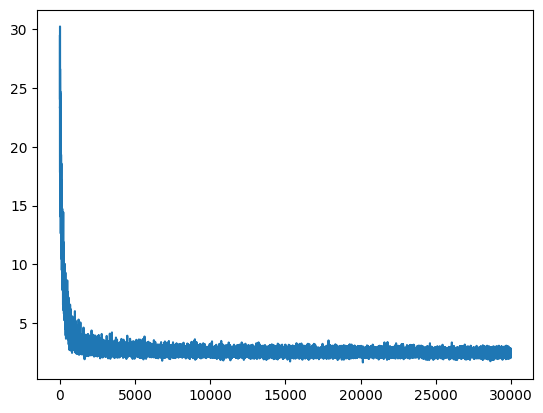

In [66]:
plt.plot(stepi, lossi)

In [67]:
# evaluate on the train dataset with increased parameters 

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4744, grad_fn=<NllLossBackward0>)

In [68]:
# evaluate on the dev dataset with increased parameters

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4641, grad_fn=<NllLossBackward0>)

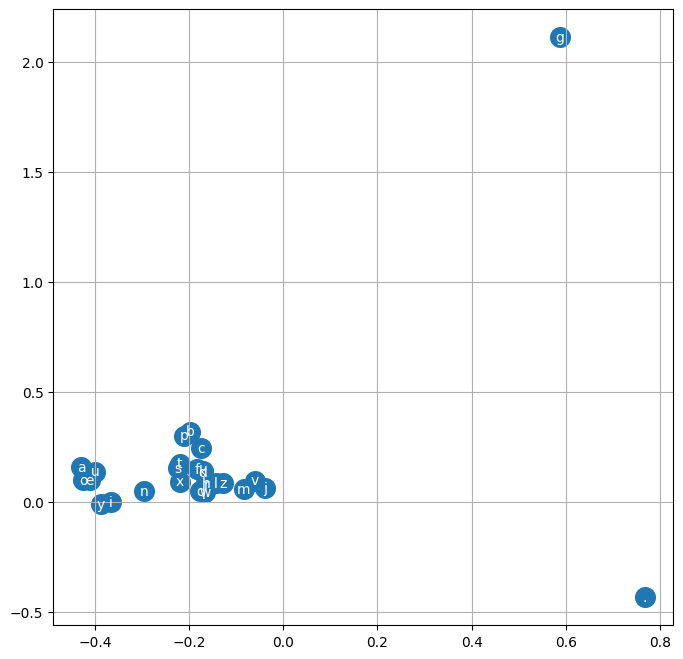

In [69]:
# visualize the embeddings trained by the neural net; clustering of letters reflects learned
# similarity of the letters 

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [70]:
# possible that the 2D C values are the constraint

In [71]:
# increase the number of vector values in C, decrease inputs to 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [72]:
sum(p.nelement() for p in parameters)

11897

In [73]:
for p in parameters:
    p.requires_grad = True

In [74]:
lri = []
lossi = []
stepi = []

In [81]:
for i in range(50000):
    # forward pass
    
    # with mini-batch:
    ix = torch.randint(0, Xtr.shape[0], (32,))  # sample size of 32
    
    emb = C[Xtr[ix]] # (32, 3, 2) based on the sample size
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    
    for p in parameters:
        p.data += - lr * p.grad  # gradient based on a smaller number of samples is less accurate
                                 # this is a trade-off for more/faster iterations of the process
     
    # tracking
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

2.872276782989502
2.7420401573181152
2.5934665203094482
2.38887357711792
2.028155565261841
2.593463659286499
2.3571419715881348
2.6243503093719482
1.9588788747787476
2.5352652072906494
2.524045467376709
2.04274320602417
2.3809916973114014
2.2512295246124268
2.3711435794830322
2.277249813079834
2.2752668857574463
2.040299654006958
2.6462697982788086
2.2379086017608643
2.3427860736846924
2.1940505504608154
2.4261956214904785
2.293076753616333
2.5903239250183105
2.3040077686309814
2.04183292388916
2.589540719985962
2.2510602474212646
2.7466917037963867
2.3670685291290283
2.1246228218078613
2.4668161869049072
2.258455991744995
2.3614094257354736
2.061250686645508
2.8375298976898193
2.4071881771087646
2.449492931365967
1.6861729621887207
2.4223172664642334
2.2536351680755615
2.060804843902588
2.5225322246551514
2.228137493133545
2.1807401180267334
2.5732054710388184
2.3504605293273926
2.5707273483276367
2.4661154747009277
2.376612663269043
2.460310935974121
2.1836957931518555
2.081852912902

2.6102123260498047
2.1826846599578857
2.5454585552215576
2.1175034046173096
2.535895347595215
2.5714428424835205
2.3949761390686035
2.667212724685669
2.6389174461364746
2.9163570404052734
2.1667628288269043
2.530667304992676
2.8548004627227783
2.8346757888793945
2.4902307987213135
2.4954724311828613
2.4392800331115723
2.671166181564331
2.3845794200897217
2.668118476867676
2.1557366847991943
2.2938530445098877
2.4057178497314453
2.514310359954834
2.295806407928467
2.5974643230438232
2.346078395843506
2.2535181045532227
2.3339908123016357
2.2503106594085693
1.8100286722183228
2.309276819229126
2.1778464317321777
2.331163167953491
2.31730055809021
2.4641025066375732
2.322124719619751
2.6424484252929688
2.7557404041290283
2.4040138721466064
2.5649261474609375
2.3567850589752197
2.651768207550049
2.3398690223693848
2.578521728515625
2.411895513534546
2.2514445781707764
2.3510653972625732
2.3328304290771484
2.517326831817627
2.3596246242523193
2.627689838409424
2.273773431777954
2.3151345252

2.207383155822754
2.4055018424987793
3.0120973587036133
2.2549033164978027
2.3311331272125244
2.0550386905670166
2.422562599182129
2.5217080116271973
3.010504961013794
2.546332359313965
2.5768144130706787
3.0566670894622803
2.2559618949890137
2.329617500305176
2.5836451053619385
2.6531260013580322
2.1051828861236572
2.076942205429077
2.0801563262939453
2.2919504642486572
2.4503955841064453
2.0564281940460205
2.416311740875244
2.5013630390167236
2.617136240005493
2.2851431369781494
2.512169361114502
2.5392329692840576
2.794156551361084
2.201219081878662
2.7498815059661865
2.43011212348938
2.2339117527008057
2.292243480682373
2.4604368209838867
2.5493664741516113
3.063699960708618
2.6993942260742188
2.7606544494628906
2.462120294570923
2.8212730884552
2.7103521823883057
2.523864269256592
2.256028413772583
2.0107803344726562
2.4657506942749023
2.2721216678619385
2.398594856262207
2.627002000808716
2.9321517944335938
2.560542345046997
2.126019239425659
2.560513973236084
2.2780051231384277


2.5040581226348877
2.80779767036438
2.7262918949127197
2.580231189727783
2.447256088256836
2.1474976539611816
2.2248551845550537
2.654376983642578
2.541346788406372
2.5225110054016113
2.0420877933502197
2.5703542232513428
2.2166175842285156
2.6154983043670654
2.586740016937256
2.4315147399902344
2.727388620376587
2.402998685836792
2.7683093547821045
2.2277064323425293
2.610208034515381
2.604142665863037
2.014819383621216
2.1841046810150146
2.6217620372772217
2.2454402446746826
2.2266244888305664
2.482727289199829
2.5421676635742188
2.4001431465148926
1.9575040340423584
2.454427480697632
2.78796648979187
2.439244508743286
2.6132569313049316
2.1733293533325195
2.414372682571411
2.3080618381500244
2.038130521774292
2.4573683738708496
2.657073736190796
2.4724066257476807
1.9046217203140259
2.4953761100769043
2.3073060512542725
2.587764263153076
2.4431040287017822
2.3483126163482666
1.9531790018081665
2.0054492950439453
2.370340347290039
2.3283987045288086
2.6169657707214355
2.2653489112854

2.1256847381591797
2.627542495727539
2.5107710361480713
2.1193947792053223
2.7343454360961914
2.2336580753326416
2.873298406600952
2.3970284461975098
2.304581642150879
2.6388297080993652
2.316178321838379
2.591054677963257
2.26432466506958
2.266080379486084
2.551769495010376
2.7751646041870117
2.808818817138672
2.5252623558044434
2.2587714195251465
2.698054313659668
2.749568462371826
2.176445484161377
2.352250099182129
2.0663700103759766
2.501638650894165
2.5037217140197754
2.4208998680114746
2.2732627391815186
2.407896041870117
2.4758713245391846
2.0810887813568115
2.542961597442627
2.2374444007873535
2.6781890392303467
2.7356514930725098
2.3570611476898193
2.3761284351348877
2.7926089763641357
2.0329298973083496
2.6177632808685303
2.3164777755737305
2.6248843669891357
2.60591983795166
2.2258412837982178
2.400960683822632
2.260542869567871
2.0579769611358643
2.9103522300720215
2.3805062770843506
2.4499711990356445
2.4104442596435547
2.4159488677978516
3.2235779762268066
2.747954845428

2.1751112937927246
2.415916681289673
2.507544755935669
2.3051676750183105
2.4774043560028076
2.3063132762908936
2.3719823360443115
2.0962891578674316
2.299243927001953
2.4683125019073486
2.0506858825683594
2.3783252239227295
2.55544376373291
2.254791021347046
2.1219913959503174
2.239525556564331
2.266873359680176
2.3252744674682617
1.9597398042678833
2.249562978744507
2.354644775390625
2.725543737411499
2.1292150020599365
2.119874954223633
2.9299263954162598
2.5726122856140137
2.7218682765960693
2.3992042541503906
2.5603904724121094
2.3526790142059326
2.8950328826904297
2.3523640632629395
2.6948699951171875
2.3339426517486572
2.347099781036377
2.431028366088867
2.2689321041107178
2.5579841136932373
2.3427414894104004
2.526538372039795
2.3979368209838867
2.3099477291107178
2.3845760822296143
2.182156801223755
2.220452070236206
2.4472475051879883
2.3897790908813477
2.4875075817108154
2.13692307472229
2.586824655532837
2.2130072116851807
2.497584342956543
2.6235013008117676
2.836792707443

2.303321361541748
3.127084970474243
1.9642987251281738
2.369478225708008
2.016618013381958
2.032529592514038
2.451707124710083
2.2462167739868164
2.4310338497161865
2.366565704345703
2.5855069160461426
2.7479207515716553
2.815063238143921
2.3437232971191406
2.506917715072632
2.2008962631225586
1.9186058044433594
2.132999897003174
2.391474723815918
1.809486985206604
2.1445488929748535
2.258739471435547
2.283090114593506
3.3645179271698
2.148988962173462
2.6290581226348877
2.5735630989074707
2.371218681335449
2.8022897243499756
2.2890374660491943
2.0464365482330322
2.2276611328125
2.520115852355957
2.423426866531372
2.838092088699341
2.241035223007202
2.187505006790161
2.8075461387634277
2.2679245471954346
2.2702348232269287
2.407628297805786
2.244821071624756
2.2597098350524902
1.9699910879135132
2.370155096054077
2.623018980026245
2.5095367431640625
2.268918991088867
2.4608571529388428
2.915536880493164
2.6678617000579834
2.3523736000061035
1.8585776090621948
1.9065454006195068
2.24883

2.1410763263702393
2.268099308013916
2.185516834259033
2.2630841732025146
2.4479892253875732
2.5368001461029053
2.105027198791504
2.6717798709869385
2.904710292816162
2.414569616317749
2.548748731613159
2.49806809425354
2.619835615158081
2.4707329273223877
2.3152997493743896
2.334796190261841
2.359379291534424
2.467161178588867
2.437697649002075
2.3981685638427734
2.5231688022613525
2.4170918464660645
2.7114555835723877
2.0864081382751465
2.4866340160369873
2.082185983657837
2.068552017211914
2.6930668354034424
2.2953381538391113
2.3580498695373535
2.1002349853515625
2.220721483230591
2.4166829586029053
2.539058208465576
2.5310707092285156
2.4618277549743652
2.2295455932617188
2.12773060798645
2.827920436859131
2.1121039390563965
2.5109164714813232
1.902679204940796
2.0675535202026367
2.639662742614746
2.1959593296051025
2.343338966369629
2.526240825653076
2.4274816513061523
2.7037856578826904
2.545304298400879
2.246737480163574
2.5303494930267334
2.4466421604156494
2.174038887023926
2

2.4091837406158447
2.226726770401001
2.9167635440826416
2.2573063373565674
2.5261800289154053
2.6011343002319336
2.6221559047698975
2.6370058059692383
2.6808197498321533
1.913502812385559
2.3963024616241455
2.302457094192505
2.153394937515259
2.2560105323791504
2.652277708053589
2.1822121143341064
2.8114173412323
2.1632583141326904
2.477973699569702
2.4430835247039795
2.3342549800872803
2.299956798553467
1.9354959726333618
2.395563840866089
2.4240565299987793
2.573240041732788
2.2368671894073486
2.2026593685150146
2.1886274814605713
2.528475522994995
2.105168342590332
2.8637795448303223
2.1801562309265137
1.7094130516052246
2.3881676197052
2.2734999656677246
2.559190511703491
2.856513261795044
2.267777681350708
2.5157840251922607
1.9731194972991943
2.435574769973755
2.542307138442993
2.644351005554199
2.132611036300659
2.0803794860839844
2.5408883094787598
2.3949012756347656
2.349278688430786
2.446622133255005
2.578545570373535
2.3098864555358887
2.590169906616211
2.9949798583984375
3.

2.685857057571411
2.2931532859802246
1.8651223182678223
2.923032522201538
2.1822421550750732
2.4474849700927734
2.5736141204833984
1.8919888734817505
2.1456656455993652
2.9599504470825195
2.19596004486084
2.1611053943634033
2.436140775680542
2.6339356899261475
2.6127636432647705
2.007633924484253
2.9155616760253906
2.4542527198791504
2.531907558441162
2.5723071098327637
2.702127456665039
2.620598316192627
2.465869426727295
2.5610861778259277
2.6491827964782715
3.067246437072754
2.432647466659546
2.5365991592407227
2.267385244369507
2.7767560482025146
2.434652805328369
2.751920461654663
2.283696413040161
1.9356807470321655
2.424259662628174
2.703217029571533
2.33603572845459
2.066377639770508
2.4208099842071533
2.5310707092285156
2.2451980113983154
2.2297518253326416
2.393115758895874
2.1652166843414307
2.5333971977233887
2.4402847290039062
2.381122589111328
1.9724997282028198
2.459670066833496
2.3385696411132812
2.577993392944336
2.349344253540039
2.2457871437072754
2.302839517593384
2

2.244379997253418
2.5379858016967773
2.138071298599243
2.643798351287842
2.105344295501709
2.5065975189208984
2.5187857151031494
2.116295099258423
1.9377145767211914
2.438023328781128
2.3199076652526855
2.3037474155426025
2.346118450164795
2.519976854324341
2.268425703048706
2.6329081058502197
2.457756280899048
2.281891345977783
2.326917886734009
2.9411966800689697
2.071192979812622
2.351006507873535
2.4500465393066406
2.407794952392578
2.361337661743164
2.563199281692505
2.361741065979004
3.0005061626434326
2.2184994220733643
2.322031259536743
2.204582929611206
2.2710800170898438
2.48895263671875
2.382044792175293
2.0791141986846924
2.6350438594818115
2.625032901763916
2.1820406913757324
2.5271294116973877
2.512925386428833
2.4549691677093506
2.6392898559570312
2.1946353912353516
1.8041526079177856
2.271658182144165
2.266407012939453
2.1233482360839844
2.7120938301086426
2.444413661956787
2.1250061988830566
2.226763963699341
2.3983657360076904
2.362523317337036
2.43697190284729
2.4812

2.210272789001465
2.6449241638183594
2.2259764671325684
2.518552541732788
2.5673463344573975
2.331488847732544
2.4155161380767822
2.596795082092285
2.3398473262786865
2.3154215812683105
2.291853666305542
1.9871469736099243
2.295459508895874
2.02067232131958
2.4847629070281982
2.406102418899536
2.1365561485290527
2.3952455520629883
2.4712412357330322
2.5236401557922363
2.3206279277801514
2.73885178565979
2.618622303009033
2.2373664379119873
1.976483941078186
2.095618963241577
2.4026830196380615
2.761934995651245
2.5490834712982178
2.544309377670288
2.2481319904327393
2.481069326400757
2.600153684616089
1.776332139968872
2.4652016162872314
2.7856521606445312
3.1050562858581543
2.646685838699341
2.413055896759033
2.3491530418395996
2.5618371963500977
2.49372935295105
2.556994676589966
2.4603281021118164
1.8961082696914673
2.3076062202453613
2.8016393184661865
2.468907594680786
1.9950052499771118
2.3023390769958496
2.8303189277648926
2.2891507148742676
2.475252151489258
2.059443712234497
2

2.1612157821655273
2.09421706199646
2.3406410217285156
2.158339262008667
2.282479763031006
2.4939916133880615
2.9689955711364746
2.084501266479492
2.276036024093628
2.1441729068756104
2.2018001079559326
2.6195220947265625
2.534841299057007
2.195096015930176
2.2038795948028564
2.9361307621002197
1.9855507612228394
2.536302328109741
2.4543304443359375
2.637537956237793
2.1018924713134766
2.459169387817383
2.4498634338378906
2.655019760131836
2.4482336044311523
2.242342710494995
2.3838469982147217
2.457637071609497
2.4738433361053467
2.320841073989868
2.26279878616333
2.5494203567504883
2.092252254486084
2.33895206451416
2.7984495162963867
2.349475622177124
2.1274502277374268
2.543572425842285
2.530820369720459
2.5269856452941895
2.4269473552703857
2.795483350753784
2.6956868171691895
2.5187630653381348
2.7877449989318848
2.766399383544922
1.9270727634429932
2.467482805252075
2.268299102783203
2.5214693546295166
2.305889368057251
1.9791109561920166
2.081181526184082
2.1238276958465576
1.9

2.244971752166748
2.1509156227111816
2.173917293548584
2.687436819076538
2.1204304695129395
2.4023587703704834
2.5377390384674072
2.698421001434326
2.5708532333374023
2.092465877532959
2.128385543823242
2.535661220550537
2.347020387649536
2.7168080806732178
2.2189321517944336
2.35945200920105
2.3478493690490723
2.281132221221924
2.536240339279175
2.1147994995117188
2.399242639541626
2.2409229278564453
2.0881500244140625
2.439329147338867
2.4251551628112793
2.6453802585601807
2.8157169818878174
2.344346046447754
2.5413413047790527
3.033687114715576
2.0820260047912598
2.2043960094451904
2.3985774517059326
2.532224655151367
2.4325478076934814
2.3475160598754883
2.273707389831543
2.166414260864258
2.717660665512085
2.4271414279937744
1.8477611541748047
2.97379207611084
2.014779806137085
2.675534725189209
2.6128036975860596
2.3299546241760254
2.2337992191314697
2.7075424194335938
2.5215003490448
2.210761070251465
2.8205974102020264
2.3155100345611572
2.074664831161499
2.8714685440063477
2.0

2.341561794281006
2.507814407348633
2.574124336242676
1.9464476108551025
2.411531925201416
2.7379465103149414
2.5079686641693115
2.52514910697937
2.130483388900757
2.3266639709472656
3.2989578247070312
2.7208845615386963
2.6369287967681885
2.3439218997955322
2.40963077545166
2.2370166778564453
2.8971197605133057
2.675018787384033
2.534759998321533
2.068091630935669
2.455941677093506
2.243986129760742
2.777740240097046
2.3511390686035156
2.7237792015075684
2.334223985671997
2.4432969093322754
2.4848382472991943
2.270967483520508
2.2793307304382324
2.5071585178375244
2.063098430633545
2.346369981765747
1.9178805351257324
2.3988113403320312
2.376945972442627
2.456503391265869
1.8130629062652588
2.1694278717041016
2.2886431217193604
2.9204022884368896
2.252842664718628
2.556786060333252
2.252796173095703
2.180677890777588
2.345454692840576
2.3974173069000244
2.1500866413116455
2.4081366062164307
2.252595901489258
2.923532009124756
2.5958893299102783
1.9427919387817383
2.800175428390503
2.2

2.567812919616699
2.2032315731048584
2.722658634185791
2.5094351768493652
2.5124309062957764
2.454530715942383
2.6361100673675537
2.2902474403381348
2.3970117568969727
2.4912033081054688
2.244863271713257
2.306957960128784
3.180809497833252
2.189518451690674
2.847731590270996
2.1333703994750977
2.2221360206604004
2.002112627029419
2.1684956550598145
2.2888951301574707
2.706127643585205
2.223569631576538
2.0340065956115723
2.20766282081604
2.4945333003997803
2.770592212677002
2.3167929649353027
2.627377510070801
2.1826670169830322
2.4878413677215576
2.897933006286621
1.948143482208252
2.3615775108337402
2.798583745956421
2.218581438064575
2.727173089981079
2.2621371746063232
2.4193367958068848
2.5013504028320312
2.1477973461151123
2.627018451690674
2.268742084503174
2.1668686866760254
2.658519983291626
2.0438413619995117
2.4323463439941406
2.3981635570526123
2.3212695121765137
2.170706033706665
2.4331367015838623
2.0645530223846436
2.4064459800720215
2.1538071632385254
2.294685363769531

2.6215012073516846
2.8838601112365723
2.219764232635498
2.5716776847839355
2.8523473739624023
2.3126072883605957
2.408802032470703
2.6300456523895264
2.4125611782073975
2.3737025260925293
1.8526312112808228
2.5586235523223877
2.25266432762146
2.3482367992401123
2.3942925930023193
2.4729158878326416
2.9112348556518555
2.438596487045288
2.2072064876556396
2.492274284362793
2.6091160774230957
2.3375959396362305
2.069542169570923
2.3558175563812256
2.654113531112671
2.7433888912200928
2.721951484680176
2.444660186767578
2.4182889461517334
2.3352108001708984
2.328932762145996
2.4355599880218506
2.1851983070373535
2.686098098754883
2.4815709590911865
2.364733934402466
2.062830924987793
2.475430488586426
2.3105757236480713
2.2756545543670654
2.5841214656829834
2.5664076805114746
2.2172491550445557
2.603020668029785
2.2031238079071045
2.326228618621826
2.100736141204834
2.3742406368255615
2.288276433944702
2.010911226272583
2.415255069732666
2.796919107437134
2.330768585205078
2.33481240272521

1.9215219020843506
2.7888500690460205
2.1705193519592285
2.4589405059814453
2.4163107872009277
2.878627061843872
2.5354180335998535
3.1460423469543457
2.167844295501709
2.1572749614715576
2.3478102684020996
2.4380924701690674
2.6561968326568604
2.349039316177368
2.6649725437164307
2.390475273132324
2.567732572555542
2.524223566055298
2.4260177612304688
2.2145819664001465
2.844606637954712
2.4922268390655518
2.130359649658203
2.752246618270874
2.248443603515625
2.3753960132598877
2.0048654079437256
2.4944965839385986
1.8527506589889526
2.780357599258423
2.3072993755340576
2.5912234783172607
2.60500168800354
2.345647096633911
2.166081666946411
2.482595920562744
2.4596357345581055
2.50374436378479
2.8975155353546143
2.289142370223999
2.621965169906616
2.5758934020996094
2.6648387908935547
2.6146790981292725
2.2154364585876465
2.4535653591156006
2.485839366912842
2.7033395767211914
2.76290225982666
2.2919859886169434
2.4697372913360596
2.314685821533203
2.2708611488342285
2.261104106903076

2.1290230751037598
2.3720178604125977
2.302382230758667
2.879307985305786
2.6256582736968994
2.2046751976013184
2.3093936443328857
2.409404754638672
2.2373528480529785
2.2999932765960693
2.482353448867798
2.9357316493988037
2.430229425430298
2.5689539909362793
2.227278232574463
2.0331714153289795
2.644761562347412
2.669740676879883
2.2989087104797363
2.3373868465423584
2.174452304840088
2.731966733932495
2.4851582050323486
2.507683277130127
2.2785589694976807
2.566615104675293
2.487884759902954
2.368791341781616
2.4637997150421143
2.011488914489746
2.545354127883911
2.6262502670288086
2.5360686779022217
3.204010486602783
2.0917129516601562
2.5074100494384766
2.4121596813201904
2.4375131130218506
2.21012020111084
2.195690155029297
2.25449800491333
2.6817805767059326
2.495020866394043
2.693492889404297
2.195749044418335
2.3954949378967285
2.3717525005340576
2.335737466812134
1.9512697458267212
1.9444386959075928
2.018005609512329
2.1619372367858887
2.215475082397461
2.613140344619751
2.2

1.99469792842865
2.1391799449920654
2.523597002029419
2.6780521869659424
2.632192373275757
2.4288992881774902
2.241304874420166
2.2882158756256104
2.211385488510132
2.4573497772216797
1.9034632444381714
2.083439588546753
2.4385974407196045
2.319516897201538
1.8847112655639648
2.0486059188842773
2.284893035888672
2.373054265975952
2.080179452896118
2.166497230529785
2.239400863647461
2.1634521484375
2.14900803565979
2.218508720397949
2.115689992904663
1.917343258857727
2.4609711170196533
2.1314210891723633
2.8097105026245117
2.7745654582977295
2.643602132797241
2.2247636318206787
2.1749653816223145
2.34055233001709
2.069615602493286
2.591116189956665
2.212575912475586
2.4652419090270996
2.0925772190093994
1.7755017280578613
2.2327768802642822
2.258657455444336
2.3219492435455322
2.464524269104004
2.5230679512023926
2.2881717681884766
2.5353543758392334
2.389838695526123
3.1416444778442383
2.2430312633514404
2.6889560222625732
1.9618263244628906
2.2295756340026855
2.4691898822784424
2.22

2.4844226837158203
2.2799274921417236
2.1241793632507324
2.43147349357605
2.3403663635253906
2.7587106227874756
2.716325521469116
2.1920416355133057
2.509823799133301
2.5323188304901123
2.5597941875457764
2.5436012744903564
2.3180973529815674
1.8592064380645752
2.77748966217041
2.5024664402008057
2.3652288913726807
2.7974071502685547
2.696723461151123
1.888645887374878
2.37446928024292
1.9903758764266968
2.550137519836426
2.398810863494873
2.1129579544067383
2.495147705078125
2.041515827178955
2.64424204826355
2.4754350185394287
2.3307688236236572
2.2713165283203125
2.6168980598449707
2.403233528137207
2.3906383514404297
2.574836015701294
2.5474560260772705
2.4796860218048096
2.109391689300537
2.37097430229187
2.2814152240753174
2.3970088958740234
2.248849391937256
2.3997280597686768
2.4929420948028564
2.1785082817077637
2.2387163639068604
2.209522008895874
2.1518943309783936
2.2906014919281006
2.15283465385437
2.409578561782837
2.5358126163482666
2.072566270828247
2.228329658508301
2.

2.4015233516693115
2.379930257797241
2.3172712326049805
2.4572360515594482
2.2862234115600586
2.3983850479125977
2.047344446182251
2.057363510131836
2.580139636993408
2.1729788780212402
2.037128448486328
2.12396502494812
2.393869161605835
2.7078936100006104
2.3495635986328125
2.1363422870635986
2.241438388824463
2.1248793601989746
2.2833611965179443
2.9455738067626953
2.7483890056610107
2.758427619934082
2.6887242794036865
2.212174415588379
2.5858137607574463
1.949386715888977
2.402064085006714
2.575697422027588
2.537280797958374
2.283447265625
2.543667793273926
2.10695481300354
2.6232221126556396
2.698167085647583
2.818667411804199
2.1553955078125
1.9718003273010254
2.455190896987915
2.5170247554779053
2.1305079460144043
2.6774704456329346
2.10036301612854
2.2903339862823486
2.270042657852173
2.279165029525757
1.8261547088623047
1.937880516052246
2.0723114013671875
2.4700818061828613
2.417545795440674
2.385873317718506
2.5165398120880127
2.559046983718872
2.23458194732666
2.2900781631

2.108459949493408
2.417262077331543
1.681188941001892
2.5487053394317627
2.218003273010254
1.9776158332824707
2.085721254348755
2.424816370010376
2.751202344894409
2.740980386734009
2.410959243774414
2.5109217166900635
2.944668769836426
2.2609336376190186
2.492302894592285
1.973089337348938
2.224789619445801
2.29014253616333
2.447183609008789
1.9767988920211792
3.0261666774749756
2.251358985900879
2.44801664352417
2.4720518589019775
2.281803607940674
2.298903226852417
2.4407572746276855
1.9595814943313599
2.6395699977874756
2.3208467960357666
2.1990292072296143
1.986438512802124
2.9140071868896484
2.5256400108337402
2.4081130027770996
2.1448872089385986
2.4927942752838135
2.327824354171753
2.4342548847198486
3.0910441875457764
2.1856632232666016
2.518759250640869
2.2822630405426025
2.3670222759246826
2.1270394325256348
2.0234248638153076
2.3783223628997803
2.4726803302764893
2.3650994300842285
2.6626553535461426
2.1849899291992188
2.731398105621338
1.9315907955169678
2.8293983936309814

2.2517499923706055
2.834001302719116
2.447791337966919
2.304377794265747
2.9588100910186768
2.2768211364746094
2.799506664276123
2.1244425773620605
2.42899751663208
2.2515954971313477
2.8201708793640137
2.6440351009368896
2.1206741333007812
2.3851540088653564
2.016143560409546
2.2550220489501953
2.4861981868743896
2.5910611152648926
2.1849396228790283
2.3432064056396484
2.2728111743927
2.6778297424316406
2.5043492317199707
1.831974744796753
2.693849802017212
2.319601535797119
2.360536813735962
2.5624518394470215
2.8039724826812744
2.580368995666504
2.26727294921875
2.3904306888580322
2.3068788051605225
2.2689714431762695
2.2321081161499023
2.531761407852173
2.308840036392212
2.4132204055786133
2.4256820678710938
2.6072165966033936
2.2803003787994385
2.525590419769287
2.270840644836426
1.7494044303894043
2.172327756881714
3.098928689956665
2.466948986053467
2.2477660179138184
2.5225253105163574
2.2684998512268066
2.604490280151367
2.469214916229248
2.4668078422546387
2.4890546798706055


2.6278645992279053
2.1503746509552
2.376314401626587
2.0597715377807617
2.235382080078125
2.149820566177368
2.0050771236419678
2.292583703994751
2.469334125518799
2.396218776702881
2.4180281162261963
2.593290090560913
2.752472162246704
2.503162145614624
2.0811498165130615
2.1704261302948
1.8479225635528564
2.8463973999023438
2.0306878089904785
2.5608725547790527
2.172091484069824
2.4923319816589355
2.2282588481903076
2.4344818592071533
2.523101806640625
2.069551706314087
2.450199604034424
2.290181875228882
2.680978775024414
2.024627923965454
2.661897659301758
2.269636869430542
2.3777174949645996
2.2623729705810547
2.764660596847534
2.1542139053344727
2.359987735748291
2.5851058959960938
2.1155922412872314
2.2034902572631836
2.7110114097595215
2.348710298538208
2.2215514183044434
2.501429557800293
2.1065335273742676
2.1737890243530273
3.016477346420288
2.447244644165039
2.2827134132385254
2.6549489498138428
2.356133222579956
2.5300943851470947
2.3106863498687744
2.330651044845581
2.0101

2.5574543476104736
2.2748403549194336
2.313603162765503
2.2915985584259033
2.277456045150757
2.1143558025360107
2.1695609092712402
2.228403329849243
2.368593215942383
2.5614938735961914
2.799086809158325
2.398404598236084
2.3755874633789062
2.6070592403411865
2.525254726409912
2.280139207839966
2.1796939373016357
2.2918272018432617
2.273923397064209
2.456331729888916
2.2703847885131836
2.510849714279175
2.8163022994995117
2.5100173950195312
2.712535858154297
2.6850311756134033
2.375156879425049
2.4570517539978027
2.388936758041382
2.839475393295288
2.4579691886901855
2.1217920780181885
2.093708038330078
2.3046061992645264
2.328433036804199
2.3069698810577393
2.2929422855377197
2.296292543411255
1.9844359159469604
2.131315231323242
2.1950271129608154
2.4981582164764404
2.3325247764587402
2.5877203941345215
2.3553099632263184
2.74013614654541
2.7460110187530518
2.9889731407165527
2.2801132202148438
2.36649227142334
2.4509177207946777
2.1394424438476562
2.5445656776428223
1.91041266918182

2.3907508850097656
2.4342195987701416
2.6754648685455322
2.466416597366333
2.6530754566192627
2.1348068714141846
2.2444911003112793
2.255664110183716
2.2436912059783936
2.420968532562256
2.3450257778167725
2.5794594287872314
2.581897258758545
2.127075672149658
2.594991683959961
2.5590803623199463
2.1914753913879395
3.0324740409851074
2.214207410812378
2.078566312789917
2.328310966491699
2.4910449981689453
2.255199670791626
2.367189884185791
2.0598902702331543
2.133967399597168
2.2434680461883545
2.2760910987854004
2.215557813644409
2.6249358654022217
2.4713783264160156
2.370276927947998
2.5885636806488037
2.6330878734588623
2.4488143920898438
2.404102325439453
2.683993101119995
2.2262496948242188
2.1465251445770264
3.020900249481201
2.2472493648529053
2.1960463523864746
2.5163071155548096
2.180511474609375
2.3604936599731445
2.4340078830718994
2.1350886821746826
2.3016889095306396
2.770781993865967
2.5580697059631348
2.6393189430236816
2.167017936706543
2.205465793609619
2.491021633148

2.2408969402313232
2.2325971126556396
2.0489108562469482
2.481332540512085
2.593533515930176
2.43224835395813
3.174030303955078
1.9623550176620483
2.499020576477051
2.5910048484802246
2.1993935108184814
2.2300527095794678
2.7405529022216797
2.381636142730713
2.0222904682159424
2.922140121459961
2.460980176925659
2.2648699283599854
2.2306065559387207
2.476958751678467
2.6820762157440186
2.3154890537261963
2.304699420928955
3.039832830429077
2.187239646911621
2.5432233810424805
2.550633430480957
2.3026137351989746
2.2033350467681885
2.5885050296783447
2.3209776878356934
2.2948131561279297
2.3225691318511963
2.0596730709075928
2.214780330657959
2.6152942180633545
2.1799991130828857
2.3019251823425293
2.615269184112549
2.0588932037353516
2.3263497352600098
2.638350009918213
2.714869499206543
2.2037386894226074
2.342520236968994
2.3576414585113525
2.163170099258423
2.638688564300537
2.358445882797241
1.9363183975219727
2.673734188079834
2.2641677856445312
2.1481754779815674
2.37020730972290

2.490886688232422
2.179157018661499
2.374506711959839
2.5517120361328125
2.699361801147461
2.5076303482055664
2.259733200073242
2.0287063121795654
2.2491798400878906
2.261829376220703
2.312903881072998
2.2891275882720947
2.1253788471221924
2.512211799621582
2.546947717666626
2.142803430557251
2.2248363494873047
2.590390205383301
2.3966293334960938
2.4456870555877686
2.029106855392456
2.065049648284912
2.2767062187194824
2.206775665283203
2.019832134246826
2.3363332748413086
2.2829458713531494
2.7157962322235107
2.1979355812072754
2.0190563201904297
2.427142858505249
1.9176793098449707
1.6855069398880005
2.403890609741211
2.627251148223877
2.224647283554077
2.8723514080047607
2.1273722648620605
2.209036111831665
2.3173911571502686
2.2610225677490234
2.0933947563171387
2.089353084564209
2.3045260906219482
2.255568027496338
2.1815521717071533
2.363727331161499
2.0811703205108643
2.610422372817993
2.729703426361084
1.765527606010437
2.166780948638916
2.3985085487365723
2.3627052307128906
2

2.421483039855957
2.482419013977051
2.2855308055877686
2.161140203475952
2.477797269821167
2.5825107097625732
2.2388229370117188
2.2320611476898193
2.3965744972229004
2.394803524017334
2.2017757892608643
2.486269474029541
2.0312931537628174
2.192741632461548
2.845533609390259
2.1941733360290527
2.1483395099639893
2.6728506088256836
2.5701749324798584
2.4712860584259033
2.3653995990753174
1.822740912437439
2.387026071548462
2.484964609146118
2.0583348274230957
1.988717794418335
2.4154317378997803
2.3339765071868896
2.1496667861938477
2.2697505950927734
2.2434401512145996
2.4614968299865723
2.206033706665039
2.329815626144409
2.4626195430755615
2.23306941986084
2.54425311088562
2.3915252685546875
2.7495195865631104
2.436110019683838
2.306661605834961
2.4566092491149902
3.0036566257476807
2.223996877670288
3.029813766479492
2.4416208267211914
2.5004618167877197
2.2130467891693115
1.9902656078338623
2.613306999206543
2.5427377223968506
2.511105537414551
2.6954915523529053
2.242452383041382

2.6367886066436768
2.2169618606567383
2.147625207901001
2.415539264678955
2.3221821784973145
2.628204107284546
2.502232551574707
2.2943341732025146
2.658095598220825
2.2816760540008545
2.1279332637786865
2.9018325805664062
1.9612208604812622
2.6197104454040527
2.0921359062194824
1.9895975589752197
2.960052251815796
2.3036248683929443
1.9469752311706543
2.139829397201538
2.1745975017547607
2.1573445796966553
2.5874879360198975
2.426262617111206
2.5113985538482666
2.501455068588257
2.073503255844116
2.776013135910034
2.6620213985443115
2.289330005645752
2.511345386505127
2.401371955871582
2.311002254486084
2.348280668258667
2.5004634857177734
1.9719308614730835
2.1828811168670654
2.4121360778808594
2.7446069717407227
2.450803518295288
2.539884328842163
2.4721126556396484
2.4588112831115723
2.0758745670318604
2.2471094131469727
2.138967275619507
2.151165008544922
2.129124402999878
2.3856492042541504
2.406783103942871
2.251293659210205
2.501461982727051
2.1090943813323975
2.680597066879272

2.283315896987915
3.0037827491760254
2.283616542816162
2.410330057144165
2.335019826889038
2.478242874145508
2.3364973068237305
2.0935559272766113
2.8730597496032715
2.3211452960968018
2.5358757972717285
2.2403738498687744
2.7847094535827637
2.36214017868042
1.8568923473358154
1.963659644126892
2.3466763496398926
2.1282191276550293
2.672177314758301
2.0096800327301025
2.7072792053222656
2.2491204738616943
2.6372575759887695
2.0119102001190186
2.3592472076416016
2.1969025135040283
2.5300676822662354
2.4439263343811035
1.9539177417755127
2.123399496078491
2.3547327518463135
2.1320834159851074
2.572654962539673
2.21333646774292
1.9263755083084106
2.28197979927063
2.5069615840911865
2.312993049621582
2.2967844009399414
2.202242374420166
2.860180616378784
2.3986692428588867
2.36714768409729
2.0256340503692627
2.367341995239258
2.2785277366638184
2.119752883911133
2.342231035232544
2.8036468029022217
2.4144368171691895
2.260573387145996
2.3042781352996826
2.1636924743652344
2.237860918045044

2.548712730407715
2.0802242755889893
2.0679092407226562
2.408822774887085
2.2914154529571533
2.118506908416748
2.651484251022339
2.2012081146240234
2.4483296871185303
2.339539051055908
2.170255661010742
2.959604024887085
2.313034772872925
2.624032735824585
2.4385271072387695
2.3606934547424316
2.259406089782715
2.5916552543640137
2.6371829509735107
2.0111172199249268
2.3447036743164062
2.290142059326172
1.9996557235717773
2.855647087097168
2.5518875122070312
2.4571597576141357
2.2310922145843506
2.346445083618164
2.3303210735321045
2.4088613986968994
2.2237720489501953
2.7674148082733154
1.9501264095306396
2.5337941646575928
2.3068008422851562
2.179520845413208
2.242680311203003
2.3087499141693115
2.226500988006592
2.2343318462371826
2.228485584259033
2.5396389961242676
1.928344964981079
1.9333778619766235
2.785470724105835
2.3380188941955566
2.386998176574707
2.299091339111328
2.4789936542510986
2.2574846744537354
2.3093361854553223
2.3407108783721924
1.8755617141723633
2.193137645721

1.9681085348129272
2.166351079940796
2.337923526763916
1.9959615468978882
2.4702494144439697
2.416907787322998
2.528782844543457
2.7015371322631836
2.132314682006836
2.3528361320495605
2.190842866897583
2.7386059761047363
2.5018553733825684
2.46476674079895
2.346656560897827
2.3601200580596924
2.3168246746063232
2.5418195724487305
2.481616497039795
2.3968915939331055
2.0037708282470703
2.400402784347534
2.5260627269744873
2.576470375061035
2.1795244216918945
2.299321174621582
2.2811977863311768
2.455576181411743
2.4787814617156982
2.296191692352295
2.2300403118133545
2.2367019653320312
2.1105923652648926
2.154834747314453
2.291196823120117
1.9935646057128906
2.2436656951904297
2.5343618392944336
2.3843111991882324
2.8402419090270996
2.4155046939849854
2.3613626956939697
2.4349374771118164
2.409050464630127
2.5255870819091797
2.4658267498016357
2.435821294784546
2.6732890605926514
2.6948585510253906
2.4141058921813965
2.4157514572143555
2.3660552501678467
2.3653159141540527
2.3603284358

2.1592116355895996
2.6770355701446533
2.4376752376556396
2.6371712684631348
2.27551531791687
2.0391407012939453
1.9465206861495972
2.4723567962646484
2.2052948474884033
2.6124701499938965
2.536190986633301
1.8089957237243652
2.455974578857422
2.024050235748291
2.1652889251708984
2.285059928894043
2.6018569469451904
2.5472512245178223
2.026890277862549
2.5218567848205566
2.47237491607666
2.1381959915161133
2.4300708770751953
2.114989757537842
2.1715006828308105
2.086514711380005
2.177846670150757
2.2785003185272217
2.2257797718048096
2.741140127182007
2.006955623626709
2.459804058074951
2.1151695251464844
3.032327651977539
2.6078879833221436
2.32205867767334
2.143540620803833
2.532336473464966
2.7599494457244873
2.0999815464019775
2.4324493408203125
3.090268850326538
2.2857506275177
2.923128366470337
2.5295403003692627
2.1068570613861084
2.4232406616210938
3.0160071849823
2.2229087352752686
2.285924196243286
1.925673246383667
2.339829206466675
2.4028546810150146
2.6340904235839844
2.098

1.963370680809021
2.5576934814453125
2.8349528312683105
2.193279504776001
2.280515193939209
3.5282816886901855
2.3709607124328613
2.3332691192626953
2.429959535598755
2.7633655071258545
2.5938618183135986
2.70041823387146
2.5475330352783203
2.4517955780029297
2.4181227684020996
2.295656204223633
2.892106056213379
1.9954442977905273
2.299950361251831
2.776841402053833
2.1017820835113525
2.4190707206726074
2.3177731037139893
1.8884074687957764
2.089911937713623
2.51518177986145
2.5055694580078125
2.110278367996216
2.193652629852295
2.3617706298828125
2.324575424194336
2.70963454246521
2.156017541885376
2.4004628658294678
2.1774301528930664
2.3217782974243164
2.367777109146118
2.034048318862915
2.346369981765747
2.4895827770233154
2.472999334335327
2.7868735790252686
2.8438615798950195
2.1583425998687744
2.5730462074279785
2.187208652496338
2.366525173187256
2.6427536010742188
2.501126527786255
2.5231142044067383
2.7550318241119385
2.2988879680633545
2.186292886734009
2.433274030685425
2.

2.8912837505340576
2.4888203144073486
2.614349126815796
2.5833611488342285
2.298456907272339
2.2837986946105957
2.546893835067749
2.317601203918457
2.5649850368499756
2.8778536319732666
2.4606659412384033
2.3646857738494873
2.256437301635742
2.590846061706543
2.360950469970703
2.4092535972595215
2.490642786026001
2.1436941623687744
2.497370958328247
2.1341006755828857
2.3911547660827637
2.4513063430786133
2.2406880855560303
2.2554855346679688
1.6961350440979004
2.71122407913208
2.5027782917022705
2.0248544216156006
2.3336844444274902
2.117140054702759
2.4165825843811035
2.144399642944336
2.3918936252593994
2.2998147010803223
2.009746789932251
2.4412550926208496
2.1831297874450684
2.3369898796081543
2.2244181632995605
2.004802703857422
2.763227701187134
2.2652485370635986
2.169057846069336
2.2242393493652344
2.419879198074341
2.2017107009887695
2.4565606117248535
2.298102617263794
2.4407129287719727
2.228864908218384
2.0220255851745605
2.472769021987915
1.8711808919906616
2.418482065200

2.234431266784668
2.301013231277466
2.6538171768188477
2.111516237258911
2.298011302947998
2.4792680740356445
2.1437151432037354
2.0183537006378174
2.497542381286621
2.905784845352173
2.284342050552368
2.7015557289123535
2.270063638687134
2.074542760848999
2.6742966175079346
2.583747625350952
2.4089035987854004
2.2045955657958984
2.1680526733398438
2.2632288932800293
2.296154499053955
2.2220871448516846
2.1258347034454346
2.4516189098358154
2.0792887210845947
2.6692445278167725
2.635530948638916
1.9320969581604004
2.582335948944092
2.3889544010162354
2.643843173980713
2.566077470779419
2.377819538116455
2.6733269691467285
2.1006360054016113
2.1652474403381348
2.222633123397827
2.2823195457458496
2.5879223346710205
2.789158582687378
2.1355414390563965
2.2621304988861084
2.70283842086792
2.5766360759735107
2.1421709060668945
2.8665387630462646
2.3808093070983887
2.2599968910217285
2.242032527923584
2.196782112121582
2.3857524394989014
2.505096912384033
2.1323330402374268
2.54698252677917

2.9686410427093506
2.8375377655029297
2.3506228923797607
2.7380363941192627
2.206462860107422
2.2237491607666016
2.305485486984253
2.4260191917419434
2.269800901412964
2.506734848022461
2.3751349449157715
2.5660698413848877
2.356407642364502
2.148653268814087
2.44290828704834
2.459644079208374
2.6461782455444336
2.392578363418579
2.3790793418884277
2.5480008125305176
2.5287084579467773
2.385629415512085
2.0828680992126465
2.6351218223571777
2.5049092769622803
2.5277810096740723
2.3581721782684326
2.246194362640381
3.1019017696380615
2.279320001602173
2.370908260345459
2.3571889400482178
2.2647483348846436
2.260568618774414
2.745783805847168
2.0380163192749023
2.0358736515045166
2.6257855892181396
2.301636219024658
2.2865357398986816
2.5452630519866943
2.3462400436401367
2.321556329727173
2.7467541694641113
2.5170669555664062
2.6886098384857178
2.467109203338623
2.2494893074035645
2.437422037124634
2.5680527687072754
2.6119117736816406
2.5531578063964844
2.0371382236480713
2.06064915657

2.3847434520721436
2.4756689071655273
2.551201343536377
2.2561709880828857
2.4638736248016357
2.6787047386169434
2.4375
2.29972243309021
2.396685838699341
2.5514273643493652
2.2564704418182373
2.4836604595184326
2.3958311080932617
2.1358563899993896
2.4778640270233154
2.576423168182373
2.252946376800537
2.4741740226745605
2.253946542739868
2.422414779663086
2.4144318103790283
2.784341812133789
2.254014730453491
2.882819652557373
2.129558801651001
2.3235437870025635
2.491642475128174
2.4136998653411865
2.458057403564453
2.7410035133361816
2.5973432064056396
2.6206412315368652
2.3609557151794434
2.2188029289245605
2.5015621185302734
2.5594937801361084
2.217710256576538
2.308382749557495
2.193758010864258
2.3109843730926514
2.213245391845703
2.643695592880249
2.618398427963257
2.333252191543579
2.720384120941162
2.6769306659698486
2.3658242225646973
2.392092704772949
2.4326491355895996
2.0659942626953125
1.993046522140503
2.3387770652770996
2.5190203189849854
2.242082118988037
2.373764038

2.385540008544922
2.583069324493408
2.4994823932647705
2.1763482093811035
2.362539052963257
2.610745429992676
2.0753324031829834
2.228001356124878
2.4704368114471436
2.3519651889801025
1.800866961479187
2.1501553058624268
2.0641043186187744
2.3753645420074463
2.158174991607666
2.0082736015319824
2.2808711528778076
2.377200126647949
2.252481698989868
2.398883581161499
2.2349131107330322
2.6486382484436035
2.672245502471924
1.9817454814910889
2.473583459854126
1.8505021333694458
2.093545436859131
2.3269569873809814
2.3011691570281982
1.925494909286499
2.2557268142700195
2.2720489501953125
2.11215877532959
2.202998638153076
2.3892452716827393
2.2232816219329834
2.339686632156372
2.526738166809082
2.455951690673828
2.281862258911133
2.2386820316314697
1.7690930366516113
2.3525760173797607
2.182803153991699
2.269049882888794
2.6392605304718018
2.35862398147583
2.182088851928711
2.196486234664917
2.2331864833831787
2.0690042972564697
2.377682685852051
2.2613046169281006
2.25657057762146
1.97

2.6162736415863037
2.1574885845184326
3.0577759742736816
2.210566520690918
2.667203903198242
2.472477674484253
2.2941300868988037
1.9566757678985596
2.3226184844970703
2.434849500656128
2.6401259899139404
2.1941869258880615
2.237626075744629
2.390187978744507
2.1380090713500977
2.3846969604492188
1.991439938545227
2.330911874771118
2.461566925048828
2.4566261768341064
2.499091386795044
2.147899627685547
2.3586621284484863
2.243567705154419
2.00960636138916
2.8116047382354736
2.511906862258911
2.585777997970581
2.05769419670105
2.5751702785491943
2.2750978469848633
2.55027174949646
2.299788236618042
2.481968641281128
2.062749147415161
2.4012551307678223
2.5354301929473877
2.366342306137085
2.8229784965515137
2.4630777835845947
2.287161350250244
2.7284882068634033
2.644845485687256
2.65952467918396
2.492274761199951
1.9952038526535034
2.4750068187713623
2.6265649795532227
2.3335413932800293
2.0001931190490723
2.1292953491210938
2.48195481300354
2.8891515731811523
2.455202102661133
2.6657

2.3047595024108887
2.9003641605377197
2.1818437576293945
2.2110581398010254
2.217355489730835
2.227090835571289
2.0919241905212402
2.6135427951812744
1.986697793006897
1.615790605545044
2.331019639968872
2.500673294067383
1.8679436445236206
1.9667720794677734
2.3562686443328857
2.229971170425415
2.2911174297332764
2.121547222137451
2.507031202316284
2.5449581146240234
2.2631845474243164
2.5989270210266113
2.383671283721924
2.643228769302368
2.3565995693206787
1.9449279308319092
2.125037670135498
2.118838310241699
2.115095376968384
2.468942165374756
2.401695966720581
2.19596004486084
1.9548900127410889
1.7512990236282349
2.6477372646331787
2.2307939529418945
2.0991005897521973
2.388885736465454
2.478219985961914
2.5981879234313965
2.1018126010894775
2.696563720703125
2.1967339515686035
2.4329535961151123
2.746720790863037
2.0916972160339355
2.302814245223999
2.687875509262085
2.6849205493927
2.595743179321289
2.8598406314849854
2.409778356552124
2.5906319618225098
2.2709121704101562
2.1

2.519871234893799
2.550192356109619
1.828512191772461
2.1796178817749023
2.3789637088775635
2.285148859024048
2.2962746620178223
1.9640052318572998
2.4914188385009766
2.3351821899414062
2.112891674041748
2.4288737773895264
2.1100432872772217
2.2676753997802734
2.3941702842712402
2.397244691848755
2.4270646572113037
2.2554221153259277
2.536104202270508
2.1478188037872314
2.818525791168213
2.2918202877044678
2.2035751342773438
2.568939208984375
2.526616096496582
2.9456796646118164
2.8310205936431885
2.2920725345611572
2.648454427719116
2.3280599117279053
2.814786195755005
2.505096912384033
2.1792540550231934
2.3870677947998047
2.2227611541748047
2.148310899734497
2.2483253479003906
2.481919050216675
2.408712387084961
2.648907423019409
2.4152116775512695
2.390697956085205
2.3677031993865967
2.7088656425476074
2.3911540508270264
2.2864229679107666
2.334257125854492
2.3911380767822266
2.234070062637329
2.388578414916992
2.176252603530884
2.4477720260620117
2.618096351623535
2.35246539115905

2.3375518321990967
2.3066611289978027
2.2268121242523193
2.529756546020508
2.488175868988037
2.477804183959961
2.167212724685669
2.1678895950317383
2.8352043628692627
2.4532506465911865
2.567464828491211
2.2006547451019287
2.0339512825012207
2.548067092895508
2.3670709133148193
2.6131556034088135
2.5849409103393555
2.3836684226989746
2.2413594722747803
2.367003917694092
1.9620734453201294
2.53110408782959
2.4884581565856934
1.9415031671524048
2.3429789543151855
1.89056396484375
3.1320385932922363
2.4536187648773193
2.2418906688690186
2.0007314682006836
2.339691400527954
2.1824185848236084
2.3684544563293457
2.295003652572632
2.8140668869018555
2.1931216716766357
2.36849045753479
2.316094398498535
2.7112014293670654
2.243788957595825
2.2754642963409424
2.5326333045959473
2.4337077140808105
2.232846260070801
2.3924171924591064
2.045750141143799
2.2799789905548096
2.2557716369628906
2.576192855834961
2.20805025100708
2.2329795360565186
2.3050930500030518
2.721250295639038
2.35335183143615

2.564671039581299
2.6588761806488037
2.6378488540649414
2.27455735206604
2.1564061641693115
2.378915786743164
2.630293369293213
2.309295177459717
2.6202054023742676
2.4605724811553955
2.7665252685546875
2.2833850383758545
2.4717442989349365
2.3147552013397217
2.373290777206421
2.0347111225128174
2.726421594619751
2.3138983249664307
2.69777774810791
2.4272453784942627
2.326815605163574
2.1882495880126953
2.22373104095459
2.5276052951812744
2.477675437927246
2.4410440921783447
3.0896389484405518
2.64056396484375
2.4868967533111572
2.323241710662842
2.2900328636169434
2.3879542350769043
2.21669864654541
2.5782110691070557
2.3222086429595947
2.6309804916381836
2.307258367538452
2.7797703742980957
2.0971903800964355
1.9552719593048096
2.1619443893432617
2.772676467895508
2.3237476348876953
2.524909734725952
2.304543972015381
2.3079376220703125
2.6550581455230713
2.4475467205047607
2.251035451889038
2.144663095474243
2.250282049179077
2.0850629806518555
2.556816816329956
2.379976272583008
2.

2.4413437843322754
2.433903932571411
1.98490309715271
2.252486228942871
2.4128575325012207
2.449307918548584
2.8185348510742188
2.407097339630127
2.1457152366638184
2.3542463779449463
2.3172926902770996
2.4853720664978027
2.2966370582580566
2.3340232372283936
2.3687996864318848
2.614391803741455
2.191826820373535
2.2178330421447754
2.171103000640869
2.643723726272583
1.9809374809265137
2.165541172027588
2.482429265975952
2.2096781730651855
2.420321464538574
2.1607983112335205
2.151604652404785
1.865119457244873
2.362913131713867
2.5955300331115723
2.7365224361419678
2.3271610736846924
2.1785857677459717
2.095754623413086
2.717684030532837
2.1329057216644287
2.135310173034668
2.1799516677856445
2.5029218196868896
2.530935525894165
2.238238573074341
2.4222359657287598
2.1824228763580322
3.012124538421631
2.268371105194092
2.680065393447876
2.354233503341675
2.5715224742889404
2.460015296936035
2.71626353263855
2.2457337379455566
3.0120506286621094
2.50748872756958
2.2285759449005127
2.32

2.298018217086792
2.2548656463623047
2.1926586627960205
2.691558837890625
2.1923210620880127
2.0820155143737793
2.296955108642578
2.41292142868042
2.65940260887146
2.17490816116333
2.329784870147705
2.4541165828704834
2.4376132488250732
2.3154213428497314
2.1208906173706055
2.3240506649017334
2.4289231300354004
2.3116397857666016
2.3741812705993652
2.221040725708008
2.3364667892456055
2.6732301712036133
2.136404514312744
2.2628135681152344
2.7619447708129883
2.198796272277832
2.329155206680298
2.4443445205688477
2.281301736831665
2.3785784244537354
2.28648042678833
2.5616166591644287
2.3508739471435547
2.1777091026306152
2.1372575759887695
2.700493097305298
2.52994441986084
2.3898658752441406
1.8194823265075684
2.227652072906494
2.52323317527771
2.363353967666626
2.5082225799560547
2.662850856781006
2.468609094619751
2.454402208328247
2.2217907905578613
2.1183929443359375
2.3060038089752197
2.2547709941864014
2.1490914821624756
2.033538579940796
1.8169268369674683
2.298534870147705
2.5

1.9763199090957642
2.4690322875976562
2.6515753269195557
3.200303077697754
2.72594952583313
2.280674934387207
2.373645305633545
1.6752228736877441
2.203037977218628
2.0988824367523193
2.207343339920044
2.171116828918457
2.272212505340576
2.4811410903930664
2.218022108078003
2.377711057662964
2.4805819988250732
2.6507134437561035
2.5724949836730957
2.1746883392333984
2.4245569705963135
2.3153762817382812
2.174804210662842
2.393141031265259
1.973845362663269
2.2508537769317627
2.3489315509796143
2.522235631942749
2.4202468395233154
1.8418875932693481
1.8888764381408691
2.0778839588165283
1.9384838342666626
2.2928521633148193
2.4192700386047363
2.4889488220214844
2.1616697311401367
2.6365842819213867
2.609750747680664
2.754530191421509
2.5157389640808105
2.0383212566375732
2.3368711471557617
2.0350663661956787
2.2327816486358643
2.062593698501587
2.2532434463500977
2.823702096939087
2.24578595161438
2.739236354827881
2.4823923110961914
2.211254835128784
2.345677375793457
2.645438671112060

1.9413745403289795
2.3724324703216553
2.0759289264678955
2.5411248207092285
2.719956398010254
2.3095505237579346
2.2194645404815674
2.679847478866577
2.2587029933929443
2.588027000427246
2.2868950366973877
2.2557320594787598
2.252744197845459
2.4300930500030518
2.1447160243988037
2.8012568950653076
2.336280107498169
2.262763500213623
2.2744719982147217
2.2945289611816406
2.4144694805145264
2.4444711208343506
2.6095399856567383
2.0457632541656494
2.7843799591064453
2.516566514968872
2.075634241104126
2.5589406490325928
2.353724718093872
2.431152582168579
2.819700241088867
2.196363687515259
2.1818134784698486
2.3719844818115234
2.6985301971435547
2.10986590385437
2.1107723712921143
1.9885085821151733
2.5916037559509277
2.2964727878570557
1.9873331785202026
2.2500102519989014
2.1164112091064453
2.880526304244995
2.548457384109497
2.291731357574463
2.69638729095459
2.2808268070220947
2.371903657913208
2.071979522705078
2.1104788780212402
2.1354639530181885
2.2610573768615723
2.568655967712

2.090954065322876
2.4244072437286377
2.6488630771636963
2.499002695083618
2.834001302719116
2.2435739040374756
2.251917839050293
2.2818996906280518
2.111604928970337
2.4095966815948486
2.5576114654541016
2.1459877490997314
3.2755377292633057
1.8621907234191895
1.9715778827667236
2.610593318939209
2.152493715286255
2.1858973503112793
2.578897714614868
2.733384132385254
2.3594367504119873
2.074795961380005
2.2804718017578125
2.516037702560425
2.1936182975769043
2.4756016731262207
2.3089888095855713
2.5557162761688232
2.4621453285217285
2.3331809043884277
2.1292896270751953
2.032947301864624
2.6226325035095215
2.74082612991333
2.149461030960083
3.158205032348633
2.287930727005005
2.0023081302642822
2.1240363121032715
2.152895212173462
2.3441715240478516
2.599886417388916
2.2229366302490234
2.286504030227661
2.5464515686035156
2.4668996334075928
2.147106647491455
2.384725570678711
2.3270466327667236
2.3325552940368652
1.9956144094467163
2.080381155014038
2.624028444290161
2.046489477157592

2.533355474472046
2.1705377101898193
2.597599506378174
2.2123265266418457
2.175647258758545
2.2565677165985107
2.322746992111206
2.0812911987304688
2.2837207317352295
2.127779483795166
2.702399730682373
2.216700792312622
2.151611804962158
2.1854631900787354
2.1095659732818604
2.1172537803649902
2.618762969970703
2.6259605884552
2.55839204788208
2.5593857765197754
2.466155767440796
2.3329389095306396
2.344223737716675
1.976789116859436
2.1504709720611572
2.446392774581909
2.2515463829040527
2.5391783714294434
2.3133811950683594
2.4409561157226562
2.8800549507141113
2.7675485610961914
2.17842173576355
2.452367067337036
2.382143497467041
2.306485652923584
2.0561180114746094
2.1887552738189697
2.352473735809326
2.4537699222564697
2.2496588230133057
2.2361207008361816
2.074828863143921
1.9444515705108643
2.5970067977905273
2.1621851921081543
2.3273468017578125
2.434429168701172
2.423022747039795
2.3760879039764404
2.5999269485473633
2.525628089904785
2.315770149230957
2.446810007095337
2.18

2.7010092735290527
2.272156000137329
2.159212112426758
2.548365831375122
2.675177574157715
2.860844373703003
2.9186604022979736
2.3354854583740234
2.1421096324920654
2.5690369606018066
2.123155355453491
2.255441665649414
2.087658643722534
2.505072832107544
2.286471366882324
2.5987844467163086
2.2682557106018066
2.9390106201171875
2.3139731884002686
2.4883053302764893
2.7496588230133057
1.9920318126678467
2.273141384124756
2.4181885719299316
2.1782443523406982
2.40895676612854
2.4183380603790283
2.071549654006958
2.2149295806884766
2.6384804248809814
2.3398401737213135
1.958311915397644
2.4337592124938965
2.153925895690918
2.107840061187744
2.334026336669922
2.247295379638672
2.1752142906188965
2.6574695110321045
2.2551281452178955
2.371596574783325
2.2735393047332764
2.010767698287964
2.4273600578308105
2.2861921787261963
2.387249708175659
2.2992255687713623
2.314727783203125
2.233340263366699
2.5602571964263916
2.966671943664551
2.3551321029663086
2.1224112510681152
2.01210618019104
2

2.3577587604522705
1.8658778667449951
2.0563106536865234
2.1682369709014893
2.495884895324707
2.5851035118103027
2.4348740577697754
2.328357458114624
2.3515982627868652
2.089141368865967
2.2046170234680176
2.379646062850952
2.2766265869140625
1.8201087713241577
2.1709330081939697
2.245997905731201
1.990530252456665
2.223008632659912
2.485954523086548
2.254387378692627
2.3770406246185303
2.566372871398926
2.042694330215454
2.671579122543335
2.7781143188476562
2.207742214202881
2.538433790206909
2.4825024604797363
2.1395604610443115
2.4847586154937744
2.102257013320923
2.3922765254974365
2.3861701488494873
2.2249882221221924
2.2164111137390137
2.277174472808838
2.3214356899261475
2.32822585105896
1.988909363746643
2.6631019115448
2.398588180541992
2.508561611175537
2.32619571685791
2.4667880535125732
1.8603198528289795
2.004417657852173
2.259856700897217
2.6739797592163086
2.122058629989624
2.204500436782837
2.2424397468566895
1.9925141334533691
2.3572163581848145
2.593602180480957
2.161

2.1518025398254395
2.3937249183654785
2.333162546157837
2.223811149597168
2.5007808208465576
2.061882257461548
2.434192657470703
2.2552649974823
2.1408398151397705
2.120605230331421
1.7797977924346924
2.4550530910491943
2.3823118209838867
2.181718349456787
2.4108715057373047
2.6317174434661865
1.9746391773223877
2.6325178146362305
2.1374621391296387
2.5740678310394287
2.262995719909668
2.359032392501831
2.269083023071289
2.252936601638794
2.1742379665374756
2.3286426067352295
2.5334622859954834
2.6804425716400146
2.243223190307617
2.0457608699798584
2.837536334991455
2.3342437744140625
2.8603274822235107
2.1552560329437256
2.548011302947998
2.1692771911621094
2.4566147327423096
2.1967315673828125
2.328709602355957
2.152674436569214
2.3561513423919678
2.3034021854400635
2.2262823581695557
2.6224961280822754
2.06506609916687
2.4838340282440186
2.465707302093506
2.419837236404419
2.1544547080993652
2.5416619777679443
2.780211925506592
2.3613648414611816
2.4853739738464355
2.46883678436279

2.6618711948394775
2.3239996433258057
2.1638147830963135
2.2005553245544434
2.349461078643799
2.9939959049224854
2.217957019805908
2.5663177967071533
1.7645673751831055
2.1980135440826416
2.114243507385254
2.3435003757476807
2.7541663646698
2.276931047439575
2.662567138671875
1.880271315574646
2.779019832611084
2.4824576377868652
2.156388759613037
1.9979031085968018
2.405999183654785
2.5432963371276855
2.770758867263794
2.041647434234619
2.0665528774261475
2.179272174835205
1.7491713762283325
2.5240542888641357
2.6073436737060547
2.3320276737213135
2.4717397689819336
3.0077097415924072
2.25799298286438
2.402991771697998
2.127209186553955
2.563292980194092
2.6964917182922363
2.530210256576538
2.2351746559143066
2.024973154067993
2.024132490158081
2.707827091217041
2.5323901176452637
2.1882381439208984
2.637911319732666
2.642900228500366
2.461158275604248
2.118572235107422
2.105915069580078
2.3943514823913574
1.9786711931228638
2.6911189556121826
2.050916910171509
2.3150901794433594
2.23

2.4516162872314453
1.9752596616744995
2.618326187133789
2.959934949874878
2.4280169010162354
2.3728549480438232
2.3119876384735107
2.4472670555114746
2.315248489379883
2.1209566593170166
2.478696823120117
2.3237059116363525
2.1934401988983154
2.479895830154419
2.3806357383728027
2.636894941329956
2.2868263721466064
2.7283852100372314
2.6185202598571777
2.563589096069336
2.244635581970215
1.8803852796554565
2.8131892681121826
2.6501026153564453
2.625955820083618
2.780938148498535
2.562081813812256
2.093679904937744
2.503702402114868
2.3860533237457275
2.5427920818328857
2.342053174972534
2.6903316974639893
2.249138832092285
1.8228267431259155
2.288835048675537
2.676619529724121
2.4744977951049805
2.1133296489715576
2.28489351272583
3.1982686519622803
2.3373115062713623
2.092261791229248
2.489818811416626
2.2150917053222656
2.414274215698242
2.2404332160949707
2.197844982147217
2.2790687084198
2.3586642742156982
2.38071870803833
2.389620780944824
2.1695961952209473
2.2039377689361572
2.7

2.065187454223633
2.286236524581909
2.1548566818237305
2.008913040161133
2.643186330795288
1.8271247148513794
2.739967107772827
2.1668989658355713
2.416428804397583
2.4844353199005127
1.7818644046783447
2.3325414657592773
2.1379003524780273
1.9455920457839966
2.3201894760131836
2.0903148651123047
2.592620372772217
2.157904624938965
2.132145404815674
2.515861988067627
2.429393768310547
2.7503662109375
2.3975515365600586
2.516360282897949
2.4817380905151367
1.9738109111785889
2.468662977218628
2.3476173877716064
2.191092014312744
2.3097569942474365
2.237171173095703
2.639512062072754
2.5095653533935547
2.295961618423462
2.7611966133117676
2.1722822189331055
2.330176830291748
2.5970327854156494
2.1099352836608887
2.346315383911133
2.328545331954956
2.2395713329315186
2.1704647541046143
2.522939682006836
2.2082972526550293
2.6360080242156982
2.2019009590148926
2.01947021484375
2.424285888671875
2.296701431274414
1.9961284399032593
2.4794983863830566
2.2244324684143066
1.9325989484786987
2.

1.7827095985412598
2.534109592437744
2.2717671394348145
2.50103759765625
2.3416409492492676
2.1832284927368164
2.633474826812744
2.3564584255218506
2.161026954650879
2.2262470722198486
2.7357380390167236
2.030113935470581
2.7789864540100098
2.5266411304473877
3.019441604614258
2.211634874343872
2.638432502746582
2.3992323875427246
2.5039236545562744
1.9443402290344238
2.2187952995300293
2.2854983806610107
2.600759983062744
2.6772522926330566
2.0597469806671143
2.257387638092041
2.472616672515869
2.87027645111084
1.9467474222183228
2.1811375617980957
2.5335237979888916
2.4532785415649414
2.139954090118408
2.4414188861846924
2.5515334606170654
2.286707878112793
2.518170118331909
2.361765146255493
2.2094688415527344
2.3325676918029785
2.4122769832611084
2.1315059661865234
2.3160927295684814
2.512540340423584
2.0754833221435547
2.4358010292053223
2.1119251251220703
2.198267936706543
2.3775696754455566
2.505793333053589
2.9770467281341553
2.6007604598999023
2.4608898162841797
2.159889936447

2.362619161605835
2.4906411170959473
2.4569027423858643
2.1336653232574463
2.367767333984375
2.4632651805877686
2.280529737472534
2.4581172466278076
2.2096946239471436
2.483853816986084
1.8453824520111084
1.9799158573150635
2.351357936859131
2.3665032386779785
2.175952196121216
2.150286912918091
2.5933926105499268
2.20062518119812
2.0819432735443115
2.7246174812316895
2.2689313888549805
1.9698649644851685
2.8305559158325195
2.3058063983917236
2.364712715148926
2.1819961071014404
2.646217107772827
2.482626438140869
2.5029618740081787
2.5648820400238037
2.0533199310302734
2.2379190921783447
2.3993780612945557
2.5355942249298096
2.155020236968994
2.1975271701812744
2.13246488571167
2.642564296722412
2.520864725112915
2.4148404598236084
2.170154333114624
2.207533836364746
2.6597769260406494
2.5980093479156494
2.463735818862915
2.262424945831299
2.149606227874756
2.516986846923828
2.3854944705963135
1.9565541744232178
2.418818712234497
2.42177152633667
2.566258192062378
2.3527774810791016
2

2.8102283477783203
2.3200182914733887
2.096055746078491
2.233877658843994
2.231052875518799
2.400057077407837
2.274770498275757
2.775860548019409
2.438115119934082
2.500843048095703
2.6110148429870605
2.2057416439056396
2.2981181144714355
1.7909266948699951
2.2793071269989014
2.9037978649139404
1.9437077045440674
2.337470531463623
2.1386289596557617
2.2243831157684326
2.3419103622436523
2.2500720024108887
2.1536998748779297
2.2329986095428467
2.5360267162323
2.515904188156128
2.6840569972991943
2.4533936977386475
2.2386817932128906
2.578885793685913
2.556406259536743
2.3811049461364746
2.526642322540283
2.4405858516693115
2.0621085166931152
2.5302326679229736
2.3915598392486572
2.7832887172698975
2.499398946762085
1.9882071018218994
2.4670841693878174
2.627560615539551
2.6311779022216797
2.5170340538024902
2.4842844009399414
2.355329990386963
2.6514291763305664
2.2811596393585205
2.413494825363159
2.5338690280914307
2.457153081893921
2.4023232460021973
2.165886163711548
2.4247140884399

2.2813570499420166
2.231879711151123
2.5837621688842773
2.32999324798584
2.3208742141723633
2.8154265880584717
2.593038558959961
2.079500913619995
2.618656635284424
2.714801073074341
2.46250581741333
2.8210012912750244
2.3734242916107178
2.0777065753936768
2.881680488586426
2.319589614868164
2.225761890411377
2.310588836669922
2.3175084590911865
2.1437315940856934
2.46360182762146
2.330976963043213
2.6580538749694824
2.1639955043792725
2.1100451946258545
2.0603208541870117
2.310112953186035
2.8707969188690186
2.093984365463257
2.290135622024536
2.051848888397217
2.176826000213623
2.135406255722046
2.3631017208099365
2.789555311203003
2.1520886421203613
2.3716049194335938
2.482700824737549
2.409273147583008
2.431504249572754
2.053821086883545
2.0103085041046143
2.3236589431762695
2.675692319869995
2.189807415008545
2.2945773601531982
2.2551069259643555
2.3017022609710693
2.336247205734253
2.29559326171875
2.185952663421631
2.414050817489624
2.174442768096924
2.276587963104248
2.50154161

2.436145782470703
2.3726119995117188
2.093660593032837
2.24359393119812
2.690314769744873
2.8900625705718994
2.08422589302063
2.169163703918457
2.224456787109375
2.5924806594848633
2.6802217960357666
2.3540709018707275
1.6844017505645752
2.3485708236694336
2.1825740337371826
2.5176937580108643
2.2981786727905273
2.6826488971710205
2.037461042404175
2.4953176975250244
2.5203235149383545
2.5114498138427734
2.201035976409912
2.139763116836548
2.405135154724121
2.521108388900757
2.137838840484619
2.157378673553467
2.718320846557617
3.1358563899993896
2.9884088039398193
2.0262486934661865
2.200470447540283
2.278520345687866
2.2344608306884766
2.430372953414917
2.1204817295074463
2.3248472213745117
2.1794772148132324
1.9753093719482422
2.182673454284668
2.176821708679199
2.436103582382202
2.3580846786499023
2.4022140502929688
2.5114126205444336
2.4003701210021973
2.4729416370391846
2.6028926372528076
2.5821402072906494
2.3089003562927246
2.124387502670288
2.2830557823181152
2.428241729736328

2.3004965782165527
2.5412533283233643
2.0655834674835205
2.087463140487671
2.3530871868133545
2.2641303539276123
2.184187412261963
1.8677676916122437
2.212189197540283
2.364834785461426
1.9303064346313477
1.9862942695617676
2.0833239555358887
2.3782598972320557
2.727388620376587
2.2736287117004395
1.908452033996582
2.89802622795105
2.5007858276367188
2.757596492767334
2.14992094039917
2.102607011795044
2.198129653930664
2.2570419311523438
2.755812406539917
2.24617075920105
2.102243423461914
2.4356613159179688
2.648829460144043
2.305762767791748
2.782978057861328
2.1627233028411865
2.5961995124816895
2.168478488922119
2.1839537620544434
2.2818000316619873
2.091613292694092
2.452855348587036
2.104757308959961
2.251044273376465
2.7498393058776855
2.637420177459717
2.6440227031707764
2.1822526454925537
2.359591245651245
2.142064094543457
2.8379154205322266
2.4778971672058105
2.0753650665283203
2.7696447372436523
2.1236562728881836
2.63051176071167
2.3992974758148193
2.2528116703033447
2.40

2.2728731632232666
2.4737422466278076
2.650484561920166
2.286235809326172
2.5095088481903076
1.9546912908554077
2.3126108646392822
2.1729488372802734
2.479379892349243
2.0099077224731445
2.194593906402588
2.499455213546753
2.049851655960083
2.6409430503845215
2.363478422164917
2.3842227458953857
2.291243553161621
2.1161839962005615
2.031363010406494
2.1455459594726562
2.142359733581543
2.1559488773345947
2.3706164360046387
2.4357011318206787
2.0341641902923584
2.266301393508911
2.4172914028167725
1.6664446592330933
2.1155855655670166
2.453725576400757
2.710658073425293
2.495905637741089
2.088634490966797
2.0870842933654785
2.2430553436279297
2.0730676651000977
2.089660167694092
2.117241144180298
2.8006207942962646
2.1489977836608887
2.2345733642578125
2.5044307708740234
2.5882809162139893
2.306286096572876
2.3695383071899414
2.3295388221740723
2.3835012912750244
2.5879695415496826
2.0290679931640625
2.114119291305542
2.463644027709961
2.416851758956909
2.5633597373962402
2.630533695220

2.5611820220947266
2.17661714553833
2.261751174926758
2.406057834625244
2.455916404724121
2.507223129272461
1.9303404092788696
2.6089766025543213
2.634211540222168
2.3326873779296875
2.288994073867798
2.28769588470459
2.539396047592163
2.142014980316162
2.463988780975342
2.394543170928955
2.381638526916504
2.3741633892059326
2.5345311164855957
2.2425007820129395
2.277597665786743
2.523650884628296
2.087207317352295
2.2129063606262207
2.0915579795837402
2.44930362701416
2.5293326377868652
2.5924055576324463
2.811513900756836
2.510071039199829
2.218437433242798
2.2654953002929688
2.7449750900268555
1.8753325939178467
2.569072723388672
2.47745680809021
2.958986282348633
2.386991262435913
2.1054916381835938
2.147341251373291
2.255784273147583
2.552273750305176
1.9232300519943237
2.3035895824432373
2.1906838417053223
2.347454071044922
2.496408224105835
1.8593809604644775
2.1457455158233643
2.3518126010894775
2.49877667427063
1.8574155569076538
2.555945873260498
2.3504481315612793
2.52240920

2.3913204669952393
2.431663751602173
2.119065284729004
2.110520839691162
2.71598482131958
2.1774466037750244
2.26355242729187
2.131964683532715
2.113962411880493
2.7821571826934814
1.9819413423538208
2.4050214290618896
2.243069648742676
2.4657397270202637
2.781620502471924
1.8303576707839966
1.8804023265838623
2.027885675430298
2.46895170211792
2.198275327682495
2.5869603157043457
2.2212884426116943
2.2976536750793457
1.8915289640426636
2.3089683055877686
2.0513956546783447
2.129537582397461
2.4612114429473877
2.5600383281707764
2.403183937072754
2.3945751190185547
2.2993102073669434
2.36782169342041
2.4158225059509277
2.727656126022339
2.0900585651397705
2.562253713607788
2.256819009780884
2.1435225009918213
2.5220587253570557
2.1397392749786377
2.349809169769287
2.348259925842285
2.088855504989624
2.3611435890197754
2.825512409210205
2.6709017753601074
2.6135103702545166
2.113067865371704
2.7033395767211914
2.3791589736938477
2.4991567134857178
2.4037790298461914
2.4015307426452637
1

2.4624991416931152
2.381969690322876
2.45874285697937
2.7518558502197266
1.9656648635864258
2.208477020263672
2.4106016159057617
2.4436585903167725
2.262155771255493
2.5511281490325928
2.2876789569854736
2.5335586071014404
2.2729456424713135
2.257307767868042
2.0085229873657227
2.3244011402130127
2.221269130706787
2.3426661491394043
2.900646448135376
2.362338066101074
1.9441252946853638
2.3223257064819336
2.562822103500366
2.17826509475708
2.0012881755828857
2.5483057498931885
2.0520968437194824
2.6199569702148438
2.178860902786255
2.725949764251709
2.5698587894439697
2.409275770187378
2.404802083969116
1.9991778135299683
2.382571220397949
2.3799400329589844
3.0042381286621094
2.2876369953155518
1.9241043329238892
3.0003039836883545
2.509047508239746
2.6207494735717773
2.144773006439209
2.4376230239868164
2.0862627029418945
2.608858585357666
2.5080718994140625
2.4845077991485596
2.7170498371124268
2.3625235557556152
2.4227027893066406
2.1242334842681885
2.1542434692382812
2.16627073287

2.261068105697632
2.1917905807495117
2.4549455642700195
2.103350877761841
2.3434369564056396
2.8829703330993652
2.6943252086639404
2.2545735836029053
2.47282338142395
2.3458404541015625
2.5997114181518555
2.189077615737915
2.1940219402313232
2.639594793319702
2.176450252532959
2.3245785236358643
2.0110340118408203
2.140727996826172
2.4994397163391113
2.463172197341919
2.2172152996063232
2.0832035541534424
2.162440538406372
2.752450704574585
2.519381046295166
3.1232941150665283
2.968500852584839
2.1574833393096924
2.615060329437256
2.2846872806549072
2.7802703380584717
2.071031332015991
2.2675721645355225
2.269350290298462
2.2712197303771973
2.479752540588379
2.051957845687866
2.3827662467956543
2.4273715019226074
2.1791279315948486
2.037064790725708
2.3311524391174316
2.7698283195495605
2.184687614440918
2.306596279144287
2.5745534896850586
2.1637299060821533
2.4192185401916504
2.075693130493164
2.810023307800293
2.1950531005859375
2.3364007472991943
2.538252353668213
2.340609788894653

2.2960524559020996
2.243272066116333
2.461601495742798
2.5371668338775635
2.651879072189331
2.13539981842041
2.202626943588257
2.3976783752441406
2.4285545349121094
2.4835548400878906
2.533879280090332
2.8095736503601074
2.4951882362365723
2.877776861190796
2.129399299621582
2.2472312450408936
1.9591648578643799
2.3114755153656006
2.5608320236206055
1.9839178323745728
2.0190341472625732
2.25812029838562
2.299522638320923
2.725475311279297
2.5689921379089355
2.1598517894744873
2.1872949600219727
2.390141248703003
2.2758400440216064
2.7928056716918945
2.290623426437378
2.20821213722229
2.305020332336426
2.223900556564331
2.6427648067474365
2.0092380046844482
2.413241386413574
2.22585391998291
2.331315279006958
2.4981675148010254
2.036276340484619
2.2897961139678955
2.1160099506378174
2.4060959815979004
2.251060962677002
2.9027323722839355
2.634974479675293
2.005289077758789
2.3250393867492676
2.6757242679595947
2.1724634170532227
2.476322889328003
2.2688331604003906
2.6332640647888184
2.

2.4760243892669678
2.224717378616333
2.056016683578491
2.7570571899414062
2.8038065433502197
1.9541525840759277
2.5649778842926025
2.4225049018859863
2.3346056938171387
2.5094821453094482
2.1065635681152344
2.935025215148926
2.2066166400909424
2.054504156112671
2.3491716384887695
2.4060027599334717
2.1577720642089844
2.5182859897613525
2.229794502258301
2.6970646381378174
2.8242013454437256
2.0666286945343018
2.1535258293151855
2.541975498199463
2.544721841812134
2.4666316509246826
1.8574178218841553
2.2375328540802
2.175191879272461
2.6257643699645996
2.446953773498535
2.546983003616333
2.0069360733032227
2.408942699432373
2.2902472019195557
2.3267836570739746
2.4400222301483154
2.691739320755005
2.1508548259735107
2.2905352115631104
2.7044217586517334
2.0613441467285156
2.6100754737854004
2.553483486175537
2.5595881938934326
2.2546567916870117
2.8528201580047607
2.236516237258911
2.6103224754333496
2.1099958419799805
2.2940266132354736
2.100921630859375
2.511683464050293
2.1378326416

2.013521432876587
2.3129849433898926
1.747801423072815
2.4375803470611572
2.725876569747925
2.312800645828247
2.662431240081787
2.5993714332580566
2.467693567276001
2.2541792392730713
2.5363247394561768
2.1562883853912354
2.085306167602539
2.221086263656616
2.192195177078247
2.310148239135742
2.2123217582702637
2.000720977783203
2.3285796642303467
2.6916229724884033
2.325397253036499
2.118265390396118
2.271392583847046
2.3063883781433105
2.2557976245880127
2.036264657974243
2.3435823917388916
2.2222702503204346
1.898259162902832
2.416356086730957
2.6462602615356445
2.2930166721343994
2.242234706878662
2.395643711090088
2.483210802078247
2.937563896179199
2.522620677947998
1.9001154899597168
2.0780322551727295
2.08526873588562
2.5143985748291016
1.9477025270462036
2.446438789367676
2.2921245098114014
2.3404815196990967
2.3233559131622314
2.105879068374634
2.4759204387664795
2.1834068298339844
2.2788946628570557
2.2390551567077637
2.3339030742645264
2.1737477779388428
2.347003936767578
1

2.324265956878662
2.2042315006256104
2.367800712585449
2.3417489528656006
2.3324060440063477
2.5924389362335205
2.1542296409606934
2.574873208999634
2.3611154556274414
2.1329174041748047
2.3464090824127197
2.1540606021881104
2.0061137676239014
2.2555713653564453
2.3838863372802734
2.44014048576355
2.372035026550293
2.4861512184143066
2.6814181804656982
2.2876079082489014
2.2177894115448
2.0941834449768066
2.561422824859619
2.427809953689575
2.510352373123169
2.2955496311187744
2.077200412750244
2.5895133018493652
2.265522003173828
2.5470898151397705
1.8929023742675781
2.549591541290283
2.7511162757873535
2.1391959190368652
2.294630527496338
2.488407611846924
2.513120651245117
2.2904486656188965
2.4626407623291016
2.4307262897491455
2.666961193084717
2.773016929626465
2.287226676940918
2.3934216499328613
2.3338286876678467
2.621893882751465
2.413918972015381
2.6934404373168945
2.4131195545196533
2.1559529304504395
2.1296582221984863
2.2727432250976562
2.379209041595459
2.263592720031738

2.1406140327453613
2.4333176612854004
2.3428378105163574
2.4922239780426025
2.207960844039917
2.519245147705078
1.8804235458374023
2.0225741863250732
2.0359792709350586
2.1237118244171143
1.8772941827774048
2.297238349914551
2.5744986534118652
2.5456011295318604
2.0984835624694824
2.867605209350586
2.4133870601654053
2.698026418685913
2.6222739219665527
2.5243961811065674
2.0257959365844727
2.5074615478515625
2.118016481399536
2.264704704284668
2.25750994682312
2.3052139282226562
2.0084033012390137
2.3118181228637695
2.2999634742736816
2.458862781524658
2.3444132804870605
2.357395648956299
2.4116673469543457
2.1252341270446777
2.231713056564331
2.608175754547119
2.420330762863159
2.6882851123809814
2.3983638286590576
1.957623839378357
2.4285640716552734
2.3602166175842285
2.094604969024658
2.295074939727783
2.230273723602295
2.2228267192840576
1.8401200771331787
2.424583911895752
2.218222141265869
2.0667121410369873
1.99922513961792
2.1201348304748535
2.0690419673919678
2.2523410320281

2.3174633979797363
2.2317543029785156
2.1323134899139404
2.5187885761260986
2.247490644454956
2.252389907836914
2.267335891723633
2.1758339405059814
2.5273425579071045
2.1424219608306885
2.161917209625244
2.2642064094543457
2.5447468757629395
2.3463501930236816
2.0064618587493896
2.087348222732544
2.295408248901367
2.538977861404419
2.4281258583068848
2.4502768516540527
2.5148444175720215
2.1492812633514404
2.5758326053619385
1.8673862218856812
2.248612642288208
2.1282081604003906
2.946244716644287
2.3340911865234375
2.7606513500213623
2.2927582263946533
2.4279470443725586
2.1898915767669678
1.9555246829986572
2.006620168685913
2.5251762866973877
2.3439860343933105
2.1939146518707275
1.922014594078064
2.4573819637298584
1.8446471691131592
2.247070550918579
2.4089362621307373
2.541585922241211
2.1597371101379395
2.090707540512085
2.702493190765381
2.615229845046997
2.2134037017822266
2.5718212127685547
2.2192444801330566
2.17197847366333
2.330031633377075
2.2841873168945312
2.1722972393

1.91243314743042
2.0472002029418945
2.4945952892303467
2.13840651512146
1.9427573680877686
2.044252395629883
2.387850522994995
2.2410943508148193
2.325686454772949
2.654350996017456
2.2446634769439697
2.5686135292053223
2.3365230560302734
1.957512378692627
2.219674825668335
2.4748892784118652
2.3333568572998047
2.4855122566223145
2.181831121444702
2.367265224456787
1.979578971862793
2.346682071685791
2.4210333824157715
2.5464322566986084
2.019970417022705
2.201798677444458
2.327293872833252
2.492858409881592
1.7968961000442505
2.635925531387329
2.4429287910461426
2.1750147342681885
2.3541672229766846
2.0797476768493652
2.3608293533325195
2.246553659439087
2.1669108867645264
2.2396843433380127
1.843395709991455
2.5265769958496094
2.4883971214294434
2.0326149463653564
2.12065052986145
2.6850876808166504
2.7237138748168945
2.148291826248169
2.6504220962524414
2.5401690006256104
2.2208878993988037
2.3530056476593018
1.8447902202606201
2.0190019607543945
2.469696044921875
2.3735604286193848

2.3209614753723145
2.354935884475708
2.8361527919769287
2.3405797481536865
2.101527452468872
2.095020055770874
2.392786741256714
2.211475133895874
2.1114110946655273
2.138946533203125
2.2139413356781006
2.295931339263916
2.2804832458496094
1.9825598001480103
2.5639686584472656
2.3962349891662598
2.4105730056762695
2.4605648517608643
2.458312749862671
2.9400923252105713
2.3261609077453613
2.2743871212005615
1.9168670177459717
2.6339454650878906
2.3492305278778076
2.171851873397827
1.9158141613006592
2.4981093406677246
2.224365472793579
2.5485475063323975
2.5963973999023438
1.8484700918197632
2.415200710296631
2.300184726715088
2.431551933288574
3.1300649642944336
2.1734042167663574
2.244969606399536
2.2894792556762695
2.791950225830078
2.055276870727539
2.2710161209106445
2.36883544921875
2.771451950073242
2.2972970008850098
2.6477582454681396
2.1466050148010254
2.445552349090576
2.369765281677246
2.205195188522339
2.2627084255218506
2.117579460144043
2.1708030700683594
2.71029376983642

2.312164783477783
2.377230167388916
2.2752726078033447
2.0966415405273438
2.5906713008880615
2.5921356678009033
2.2135207653045654
2.549283027648926
2.09942889213562
1.988879919052124
1.8981776237487793
2.7324378490448
2.3340320587158203
2.62707257270813
2.704885482788086
2.6810801029205322
2.5625076293945312
2.051802396774292
1.7759135961532593
2.3655552864074707
1.9921869039535522
1.8666620254516602
2.7355475425720215
2.1295549869537354
2.5310089588165283
2.1922876834869385
2.363417625427246
2.6517510414123535
2.259340286254883
2.496988534927368
2.3178036212921143
2.8084793090820312
2.375887870788574
2.5344181060791016
2.102604627609253
2.555182456970215
2.2474987506866455
2.0136685371398926
2.26419734954834
2.342660903930664
2.099181890487671
2.671297311782837
2.226362466812134
2.694878101348877
2.155855894088745
2.7687931060791016
2.8589537143707275
2.6849560737609863
2.2798876762390137
1.9737217426300049
2.3716888427734375
2.237483024597168
2.1691830158233643
2.523798942565918
1.9

2.0542097091674805
2.591994285583496
2.076622724533081
2.427208423614502
2.722667932510376
2.101283311843872
2.7178730964660645
2.1669113636016846
2.6746315956115723
1.8946295976638794
2.454631805419922
2.360736608505249
2.388193368911743
2.168267011642456
2.357553482055664
2.3199691772460938
2.323270559310913
1.9053475856781006
2.925358295440674
2.4046313762664795
2.9027884006500244
2.465872049331665
2.1267902851104736
2.7844371795654297
2.4477450847625732
2.5585296154022217
2.237321376800537
2.1063742637634277
2.488835573196411
2.272658348083496
2.4256231784820557
2.269732713699341
2.1327106952667236
2.3934261798858643
2.0746171474456787
2.2468481063842773
2.2001736164093018
2.462205410003662
2.5083343982696533
2.1532204151153564
2.4308526515960693
2.207292318344116
2.653653860092163
2.2768752574920654
2.4157657623291016
2.2945892810821533
2.2246131896972656
2.0569190979003906
2.698435068130493
2.0199484825134277
2.2256505489349365
1.9808305501937866
2.254185199737549
2.4600574970245

2.632237672805786
2.621724843978882
2.568174123764038
2.025116443634033
2.1134660243988037
2.7112009525299072
2.1927289962768555
2.044999122619629
2.4393367767333984
2.6547977924346924
2.034396171569824
2.6061925888061523
1.9200993776321411
2.479844093322754
2.393319606781006
2.585756301879883
2.671766519546509
2.0952091217041016
2.322908401489258
1.8493354320526123
2.34837007522583
2.3157408237457275
2.394172430038452
2.4165520668029785
2.9437108039855957
2.273580312728882
2.3775441646575928
2.538424015045166
2.21547794342041
2.069857358932495
2.4156501293182373
2.0809030532836914
2.3129208087921143
2.4153835773468018
2.3135147094726562
2.5584068298339844
3.013256072998047
2.400021553039551
2.2149579524993896
2.3564586639404297
2.370476245880127
2.700345516204834
2.529242992401123
2.800250291824341
2.334836483001709
2.328178644180298
1.9040197134017944
2.13480281829834
2.1813735961914062
2.1243789196014404
2.183650493621826
2.5208590030670166
2.7740159034729004
2.5493974685668945
2.10

2.2869808673858643
2.2883315086364746
2.4130349159240723
2.5771708488464355
2.3439958095550537
2.0458459854125977
2.363478660583496
2.0893754959106445
2.0948681831359863
2.352160692214966
2.256844997406006
2.3348259925842285
2.1718273162841797
2.370159387588501
2.339967966079712
2.181992530822754
2.737622022628784
2.605254888534546
2.3828935623168945
2.458308458328247
2.235687732696533
2.1533875465393066
2.2476906776428223
2.7954890727996826
2.8646161556243896
2.446537971496582
1.8863916397094727
2.2795591354370117
2.7419791221618652
2.3124115467071533
2.112987756729126
2.1229217052459717
2.5508203506469727
2.2425899505615234
2.351633071899414
2.016136646270752
2.864421844482422
2.3214290142059326
2.373373031616211
2.0594847202301025
2.2962658405303955
2.5634279251098633
2.3466906547546387
2.0690090656280518
2.1176209449768066
2.009120225906372
2.4274513721466064
2.0171546936035156
2.4768917560577393
2.3957903385162354
2.2496466636657715
2.1691112518310547
2.528703212738037
2.340402126

2.7943849563598633
2.0990352630615234
2.0429296493530273
2.536149024963379
2.6416616439819336
2.3044936656951904
2.4238805770874023
2.083935022354126
2.8504390716552734
2.531266689300537
2.3122096061706543
2.2352609634399414
2.362399101257324
2.4065282344818115
2.1331663131713867
2.6935040950775146
2.5961685180664062
2.172823190689087
2.554515838623047
2.004574775695801
2.3785641193389893
2.4277610778808594
2.7083940505981445
2.604635715484619
2.467851400375366
2.166562795639038
2.5706615447998047
2.216482162475586
2.291412353515625
2.022477626800537
1.9460057020187378
2.4138944149017334
1.874943494796753
2.329265594482422
2.240050792694092
2.433499813079834
2.1563966274261475
2.3217368125915527
2.3140146732330322
2.0601985454559326
2.5516226291656494
2.505239963531494
2.1405692100524902
2.2025721073150635
2.186135768890381
2.438325881958008
2.4218850135803223
2.2585320472717285
2.4011826515197754
2.834735870361328
2.2336697578430176
2.426072359085083
2.5526487827301025
2.7623260021209

2.0530271530151367
2.8139829635620117
2.6431961059570312
2.509232521057129
2.376415729522705
2.788280487060547
2.464143991470337
2.4271116256713867
2.7555489540100098
2.2855112552642822
2.5208065509796143
2.5054268836975098
2.546142339706421
2.7659435272216797
2.417513370513916
2.4539272785186768
2.1169564723968506
3.0343422889709473
2.205686569213867
2.7447195053100586
2.595191478729248
2.2858433723449707
2.088907480239868
2.51759672164917
2.6979076862335205
2.0696167945861816
2.5932259559631348
2.278716802597046
2.3185620307922363
2.1809208393096924
2.088249444961548
2.205719470977783
2.4869797229766846
2.425398588180542
2.0615875720977783
2.1973607540130615
2.3080365657806396
2.872493028640747
2.092663288116455
2.5332391262054443
2.658991575241089
2.134830951690674
2.389063835144043
2.16428542137146
2.292231559753418
2.096548318862915
2.3933563232421875
2.425307035446167
2.5237815380096436
2.472644567489624
2.8471250534057617
2.3910703659057617
2.225724697113037
2.2804174423217773
2

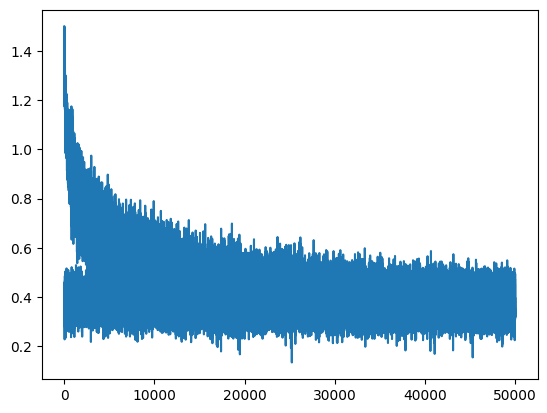

In [82]:
plt.plot(stepi, lossi)

In [83]:
# evaluate on the train dataset with increased parameters 

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3383, grad_fn=<NllLossBackward0>)

In [84]:
# evaluate on the dev dataset with increased parameters

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3497, grad_fn=<NllLossBackward0>)

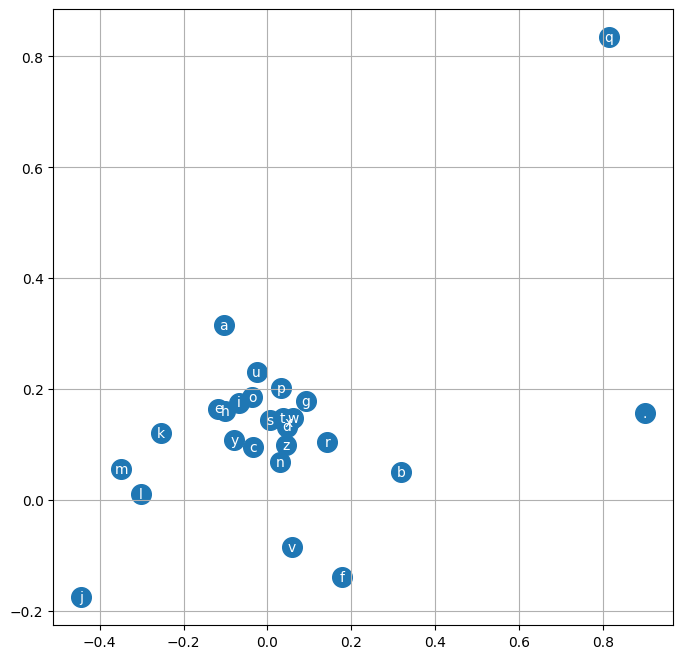

In [85]:
# visualize the embeddings trained by the neural net; clustering of letters reflects learned
# similarity of the letters 

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [86]:
# to display output names
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



carlaiza.
jelle.
fisdrix.
thty.
salaysa.
jazhenn.
dellynt.
kaqui.
nelania.
chaiivin.
leig.
dham.
jore.
quinn.
sroj.
walia.
biyos.
elog.
jaryxi.
jaxee.
